In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import sklearn.preprocessing as pre
from pandas import DataFrame
from pandas import concat
from scipy.stats import linregress as lr
from scipy.signal import find_peaks as find_peaks
from scipy.fftpack import fft, ifft,rfft
from sklearn.decomposition import PCA

patient = 1

# 0. Preprocessing and Reading Data

In [2]:
cgmSeries = pd.read_csv("DataFolder/CGMDatenumLunchPat" + str(patient) + ".csv")
cgmData = pd.read_csv("DataFolder/CGMSeriesLunchPat" + str(patient) + ".csv")
cgmData = cgmData.mask(cgmData.eq(-1)).ffill(axis=1)
insulinBasal = pd.read_csv("DataFolder/InsulinBasalLunchPat" + str(patient) + ".csv")
insulinBasal = insulinBasal.fillna(0)
insulinBolus = pd.read_csv("DataFolder/InsulinBolusLunchPat" + str(patient) + ".csv")
insulinBolus = insulinBolus.fillna(0)
insulinTime = pd.read_csv("DataFolder/InsulinDatenumLunchPat" + str(patient) + ".csv")

# Remove Empty Rows
zero_entries = cgmData.isna().any(axis=1)
cgmData = cgmData[zero_entries == False]

cgmSeries = cgmSeries[zero_entries == False]
insulinBasal = insulinBasal[zero_entries == False]
insulinBolus = insulinBolus[zero_entries == False]
insulinTime = insulinTime[zero_entries == False]

In [3]:
reading_no = 1
# Normalize CGMValues
cgmValues_np = cgmData.values
cgmNorm_np = pre.minmax_scale(cgmValues_np, axis=1)

# CGM Timeseries
cgmSeries_np = cgmSeries.values
timeMins = np.nanmin(cgmSeries_np, axis=1)
cgmSeries_np = cgmSeries_np - timeMins[:, None]

# Normalize insulinBasal
insulinBasal_np = insulinBasal.values
insulinBasalNorm_np = pre.minmax_scale(insulinBasal_np, axis=1)

# Normalize insulinBolus
insulinBolus_np = insulinBolus.values
insulinBolusNorm_np = pre.minmax_scale(insulinBolus_np, axis=1)

# Insluin Timeseries
insulinTime_np = insulinTime.values - timeMins[:, None]

# 1.a Anirudh Features

In [4]:
# Slope between max and min
maxs = np.argmax(cgmNorm_np, axis=1)
mins = [np.argmin(cgmNorm_np[i, maxs[i]:])+maxs[i] for i in range(len(maxs))]

slopes = []
time_diffs = []
for i in range(len(maxs)):
    slope = (cgmNorm_np[i][maxs[i]]-cgmNorm_np[i][mins[i]])/(cgmSeries_np[i][maxs[i]]-cgmSeries_np[i][mins[i]])
    time_diffs.append(cgmSeries_np[i][maxs[i]]-cgmSeries_np[i][mins[i]])
    slopes.append(slope)
    
slopes = np.nan_to_num(slopes)
time_diffs = np.nan_to_num(time_diffs)

/home/omkar/.local/lib/python3.5/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


In [5]:
# Regression Error
reg_window_size = 4
reg_errors = []
peak_values = []
peak_heights = []
peak_time_diffs = []
peak_times = []
for j in range(len(cgmNorm_np)):
    errors = np.array([])
    for i in range(len(cgmNorm_np[j])-reg_window_size):
        times = cgmSeries_np[j][i:i+reg_window_size-1]
        if np.isnan(times).any():
            errors = np.append(errors, -1)
            continue
        coeffs = np.polyfit(times, cgmNorm_np[j][i:i+reg_window_size-1], 1)
        poly = np.poly1d(coeffs)
        error = poly(cgmSeries_np[j][i+reg_window_size])-cgmNorm_np[j][i+reg_window_size];
        errors = np.append(errors, error)
    peaks, height_dict = find_peaks(errors, height = 0)
    heights = height_dict['peak_heights']
    sorted_args = heights.argsort()
    peaks = peaks[sorted_args]
    peaks = peaks[-2:]
    heights = heights[sorted_args]
    heights = heights[-2:]
    values = cgmNorm_np[j][peaks+reg_window_size-1]
    times = cgmSeries_np[j][peaks+reg_window_size]
    times2 = cgmSeries_np[j][peaks+reg_window_size-1]
    reg_errors.append(errors)
    while(len(values) < 2):
        values = np.append(values, 0)
        heights = np.append(heights, 0)
        times = np.append(times, 0)
        times2 = np.append(times2, 0)
    peak_values.append(values)
    peak_heights.append(heights)
    peak_time_diffs.append(times)
    peak_times.append(times2)
reg_errors = np.array(reg_errors)

11.52000006866455
0.08680555503815413


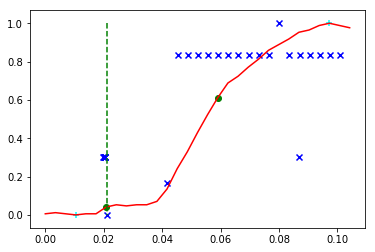

[0.04117647 0.61176471]
[0.04509804 0.08039214]
[0.02083333 0.05902778]


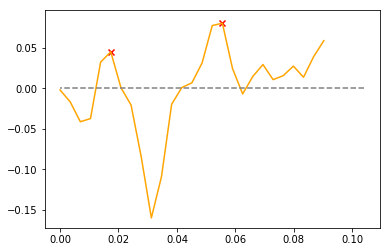

20.571428615219737
0.048611111007630825


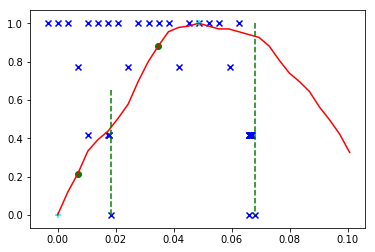

[0.21481481 0.88148148]
[0.11358025 0.12839506]
[0.00694444 0.03472222]


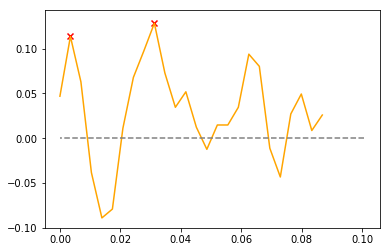

13.714285677793074
0.0729166668606922


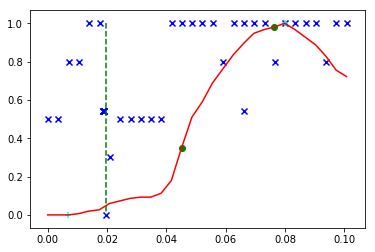

[0.98013245 0.35099338]
[0.10706401 0.14900665]
[0.07638889 0.04513889]


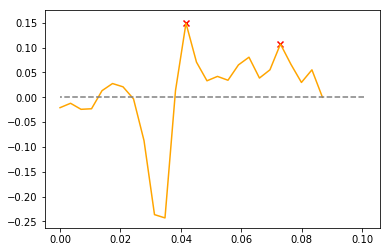

13.090909053225163
0.0763888891087845


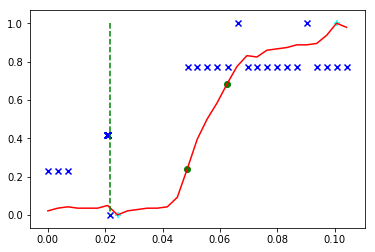

[0.23943662 0.68309859]
[0.11619722 0.15140845]
[0.04861111 0.0625    ]


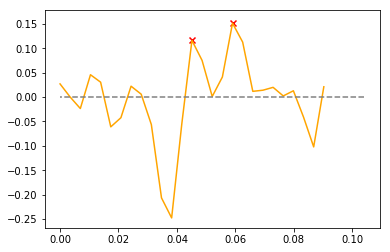

32.0
0.03125


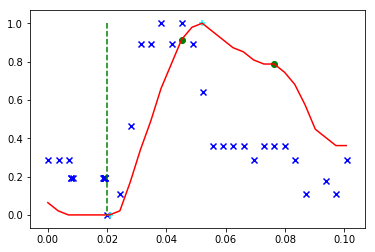

[0.78723404 0.91489362]
[0.13475178 0.22340426]
[0.07638889 0.04513889]


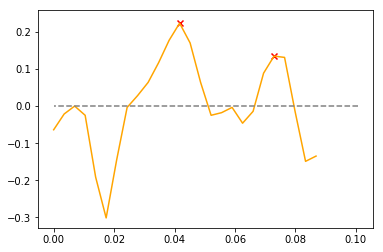

15.15789457041141
0.06597222294658422


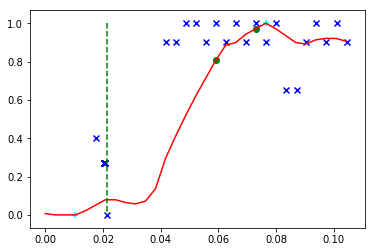

[0.8057554  0.97122302]
[0.11031174 0.12350121]
[0.05902778 0.07291667]


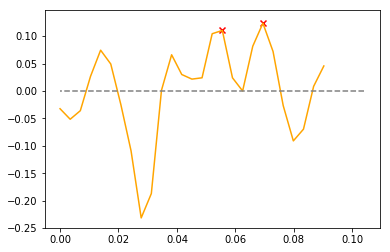

32.0
0.03125


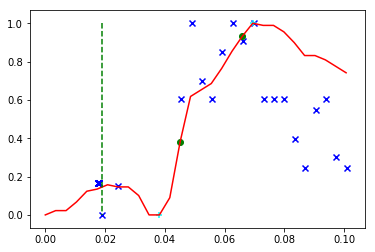

[0.93258427 0.38202247]
[0.15543071 0.46067417]
[0.0659838  0.04515046]


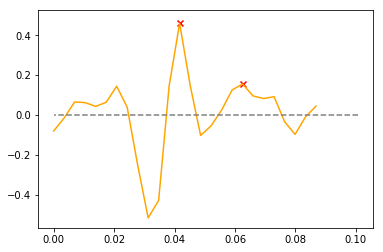

13.714285634001907
0.07291666709352285


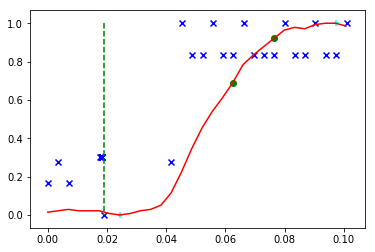

[0.69064748 0.92086331]
[0.08033575 0.08273381]
[0.0625     0.07638889]


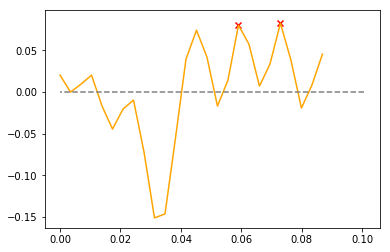

10.666666666666666
0.09375


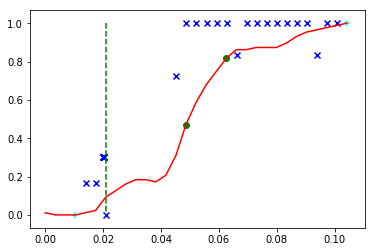

[0.81609195 0.47126437]
[0.10153257 0.11877395]
[0.0625     0.04861111]


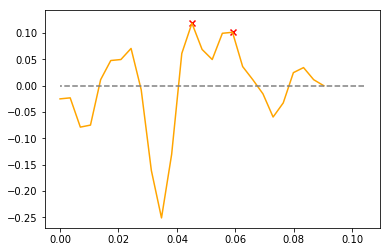

19.187208368406285
0.05211805598810315


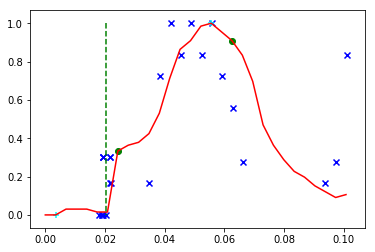

[0.90909091 0.33333333]
[0.25757581 0.28282827]
[0.06253472 0.02430556]


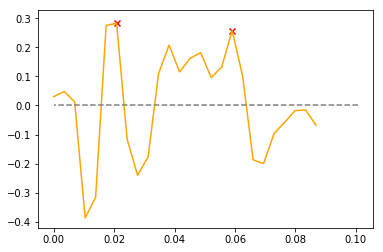

16.941176411189836
0.05902777798473835


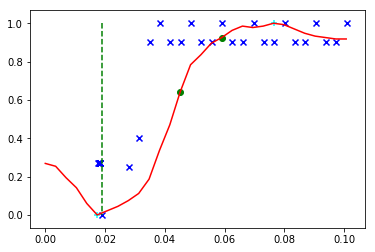

[0.92537313 0.64179104]
[0.05721393 0.20024877]
[0.05902778 0.04513889]


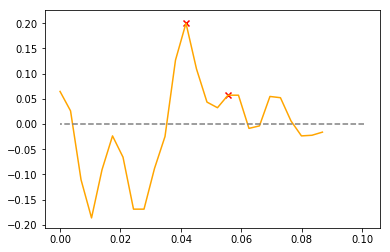

16.0
0.0625


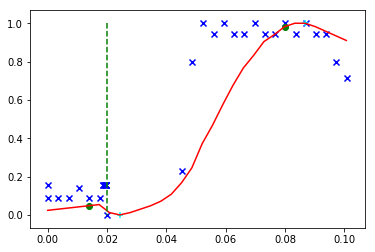

[0.04790419 0.98203593]
[0.06087825 0.08083833]
[0.01388889 0.07986111]


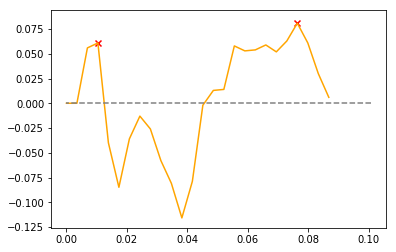

16.0
0.0625


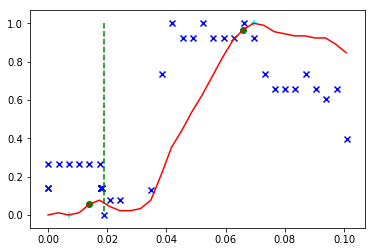

[0.05494505 0.96703297]
[0.11904763 0.13553114]
[0.01390046 0.0659838 ]


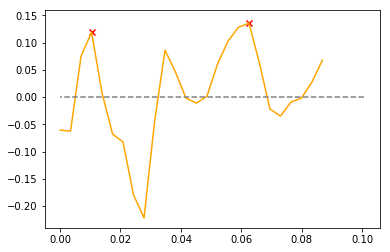

18.003750966506455
0.05554398091044277


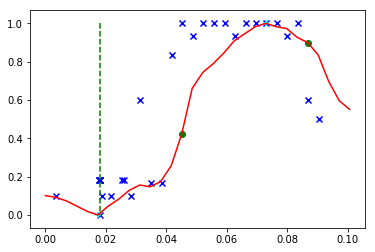

[0.89908257 0.42201835]
[0.14067275 0.28134555]
[0.08679398 0.04512731]


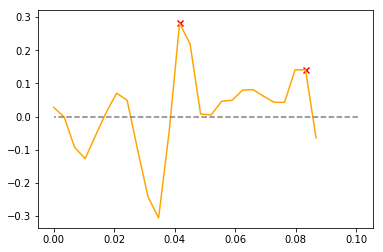

10.66666666666667
0.09375


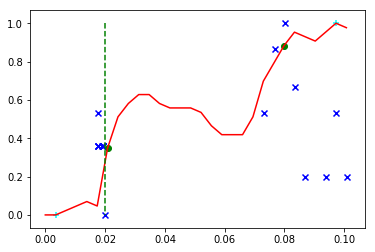

[0.88372093 0.34883721]
[0.20930232 0.35271316]
[0.07986111 0.02083333]


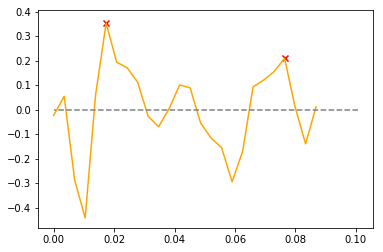

14.400000061690807
0.06944444414693862


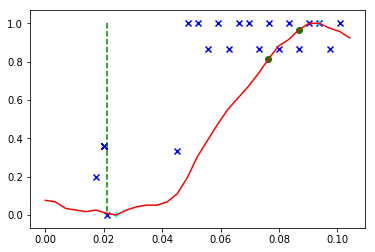

[0.81355932 0.96610169]
[0.05649719 0.11440678]
[0.07638889 0.08680556]


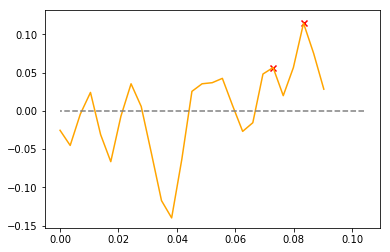

26.18181838575474
0.03819444414693862


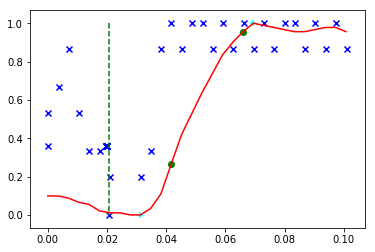

[0.26373626 0.95604396]
[0.08791205 0.12087912]
[0.04166667 0.06597222]


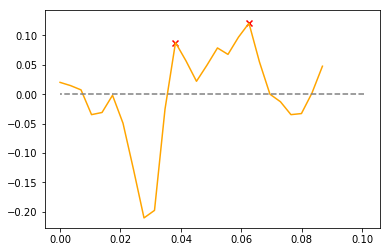

10.000000204890977
0.020833332906477153


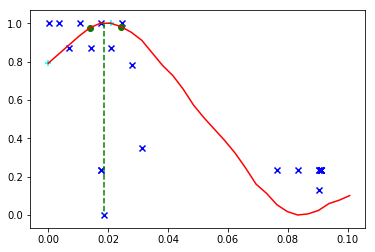

[0.98214286 0.97619048]
[0.06349205 0.08630953]
[0.02430555 0.01388889]


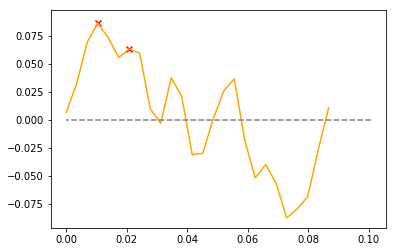

12.521738982380906
0.07986111205536872


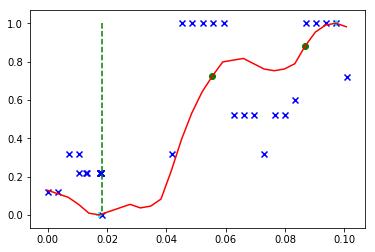

[0.88073394 0.72477064]
[0.12385322 0.13761468]
[0.08680556 0.05555556]


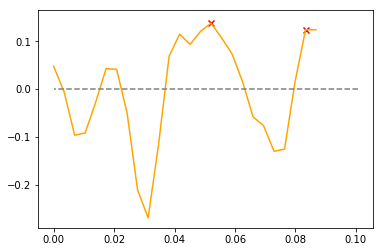

13.714285655897495
0.07291666697710752


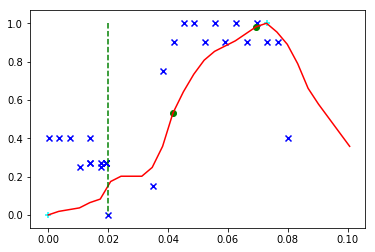

[0.53211009 0.98165138]
[0.12232416 0.16819574]
[0.04166667 0.06944444]


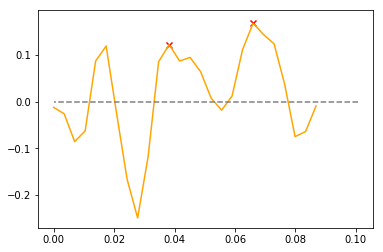

15.155235985476072
0.06598379602655768


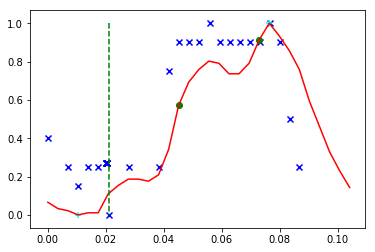

[0.57142857 0.91208791]
[0.24565298 0.35347988]
[0.04513889 0.07292824]


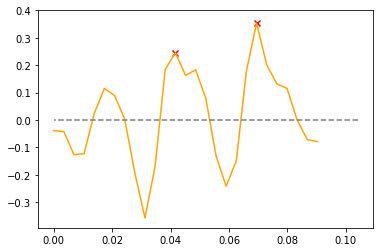

0.0
0.0


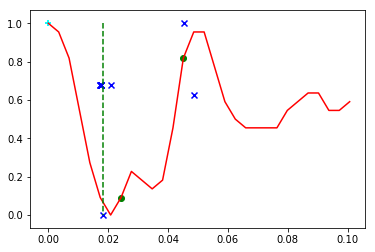

[0.09090909 0.81818182]
[0.31818183 0.71212124]
[0.02430556 0.04513889]


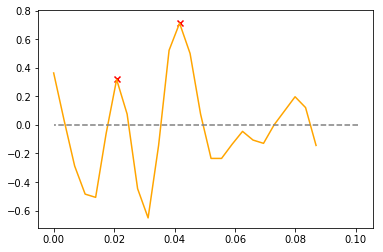

18.00000016763807
0.055555555038154125


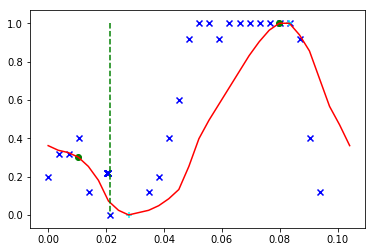

[0.30120482 1.        ]
[0.11445783 0.18473894]
[0.01041667 0.07986111]


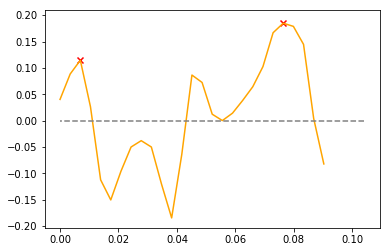

18.000000167638063
0.055555555038154125


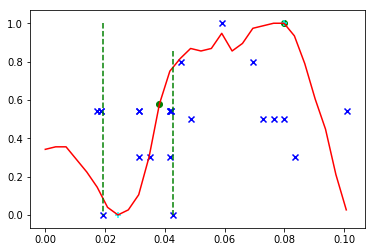

[1.         0.57894737]
[0.2697368  0.33114033]
[0.07986111 0.03819444]


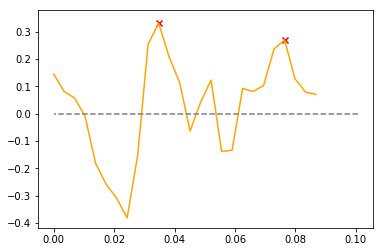

16.000000000000004
0.0625


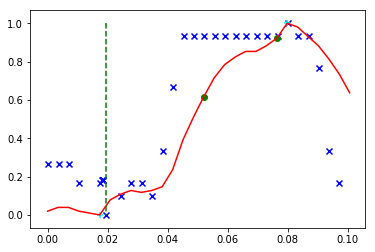

[0.61764706 0.92156863]
[0.1029412  0.19117648]
[0.05208333 0.07638889]


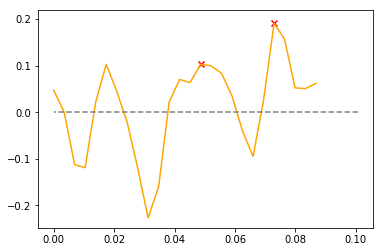

20.571428565954673
0.04861111112404615


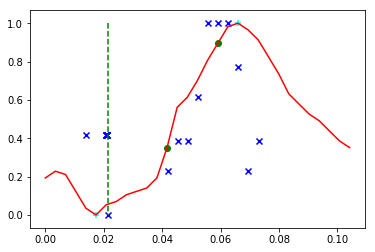

[0.89473684 0.35087719]
[0.20175439 0.2222222 ]
[0.05902778 0.04166667]


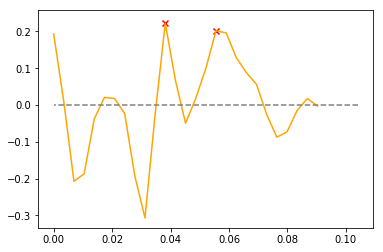

0.0
0.0


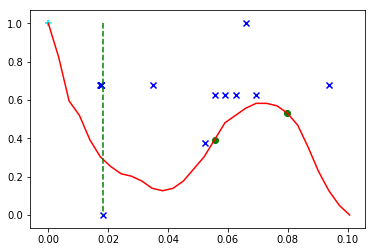

[0.39240506 0.53164557]
[0.10126581 0.14135018]
[0.05555556 0.07986111]


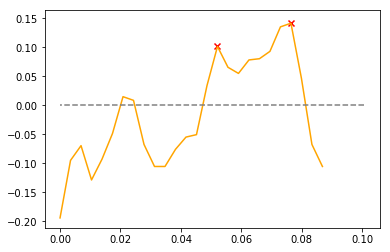

0.0
0.0


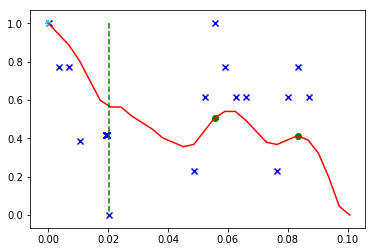

[0.50574713 0.4137931 ]
[0.15708812 0.20498087]
[0.05555556 0.08333333]


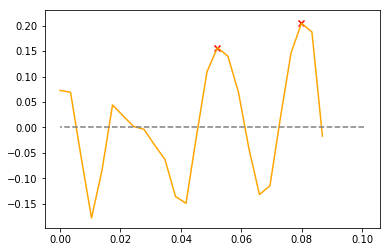

11.999999910593033
0.08333333395421505


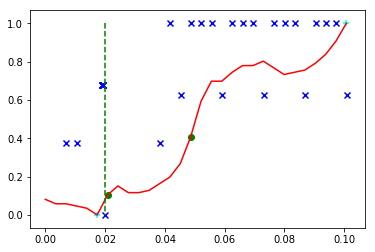

[0.10465116 0.40697674]
[0.18023256 0.23837207]
[0.02083333 0.04861111]


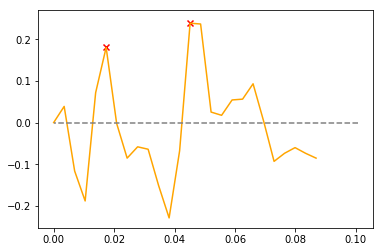

0.0
0.0


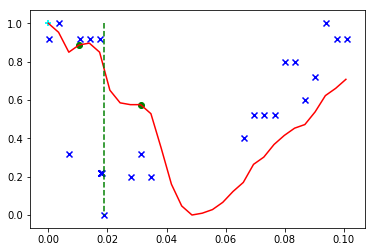

[0.88679245 0.5754717 ]
[0.31761003 0.32232701]
[0.01041667 0.03125   ]


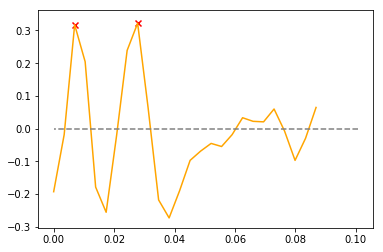

32.76190561623802
0.024305554921738803


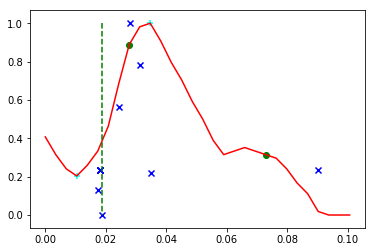

[0.31481481 0.88888889]
[0.09567903 0.38888889]
[0.07291667 0.02777778]


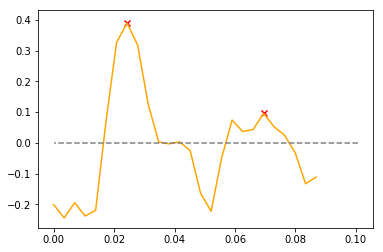

16.93453572002204
0.05905092507600784


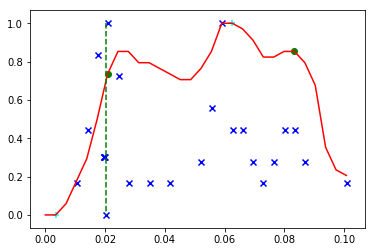

[0.85294118 0.73529412]
[0.41666666 0.42156864]
[0.08335648 0.02083333]


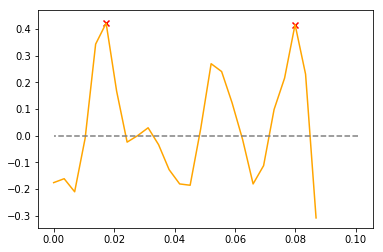

15.999999999999998
0.0625


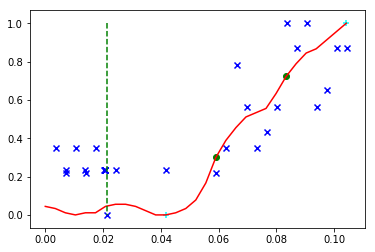

[0.72222222 0.3       ]
[0.08333332 0.10185187]
[0.08333333 0.05902778]


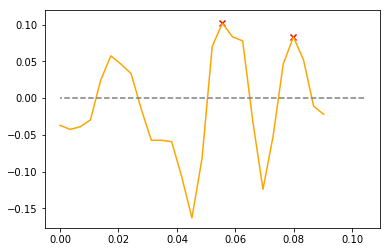

In [6]:
# Visualize
for i in range(0, len(cgmSeries_np)):
    print(slopes[i])
    print(time_diffs[i])
    plt.figure()
    plt.plot(cgmSeries_np[i], cgmNorm_np[i], c='red')
    plt.scatter(insulinTime_np[i], insulinBasalNorm_np[i], marker='x', c='blue')
    plt.scatter(peak_times[i], peak_values[i], marker='o', c='green')
    plt.scatter(cgmSeries_np[i][maxs[i]], cgmNorm_np[i][maxs[i]], marker='+', c='cyan')
    plt.scatter(cgmSeries_np[i][mins[i]], cgmNorm_np[i][mins[i]], marker='+', c='cyan')
    insulinBolusNon = insulinBolusNorm_np[i]
    insulinTimesNon = insulinTime_np[i]
    insulinTimesNon = insulinTimesNon[np.nonzero(insulinBolusNon)]
    insulinBolusNon = insulinBolusNon[np.nonzero(insulinBolusNon)]
    for j in range(0, len(insulinBolusNon)):
        plt.plot([insulinTimesNon[j], insulinTimesNon[j]], [insulinBolusNon[j], 0], c='green', linestyle='dashed')
    plt.show()
    print(peak_values[i])
    print(peak_heights[i])
    print(peak_times[i])
    plt.figure()
    plt.plot(cgmSeries_np[i][reg_window_size:], reg_errors[i], c='orange')
    plt.plot(cgmSeries_np[i], np.zeros(len(cgmSeries_np[i])), c='gray', linestyle='dashed')
    plt.scatter(peak_time_diffs[i], peak_heights[i], c='red', marker='x')
    plt.show()    

# 1.b Vedant Features

In [7]:
# Windowed features
window_mins = []
window_maxs = []
window_means = []
window_vars = []
for i in range(0, len(cgmSeries_np)):
    window_input = DataFrame(cgmNorm_np[i][::-1])
    width=5
    shifted=window_input.shift(width - 1)
    window=shifted.rolling(window=width)
    dataframe=concat([window.var(), window.min(),  window.mean(), window.max() ], axis=1)
    dataframe.columns = ['var', 'min', 'mean', 'max']
    window_features = dataframe.nlargest(2,'var')
    window_values = window_features.values
    window_mins.append([window_values[0][1], window_values[1][1]])
    window_maxs.append([window_values[0][3], window_values[1][3]])
    window_vars.append([window_values[0][0], window_values[1][0]])
    window_means.append([window_values[0][2], window_values[1][2]])

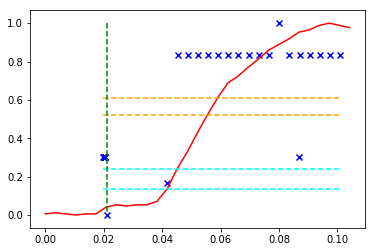

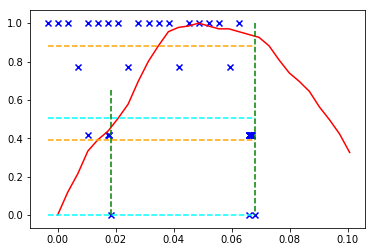

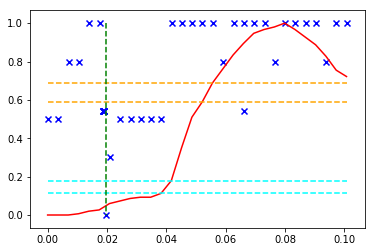

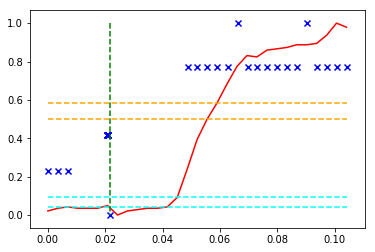

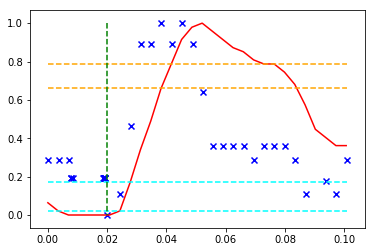

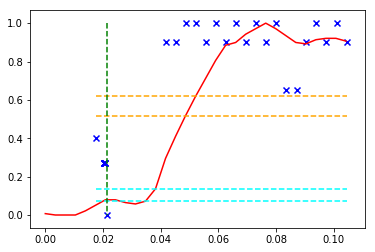

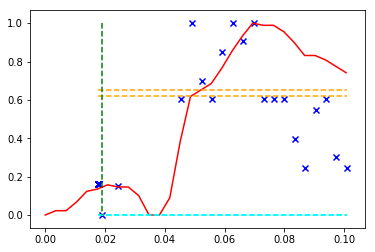

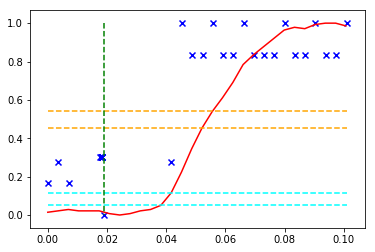

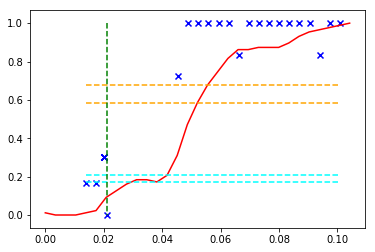

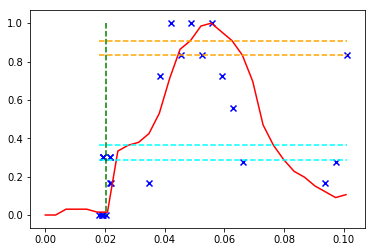

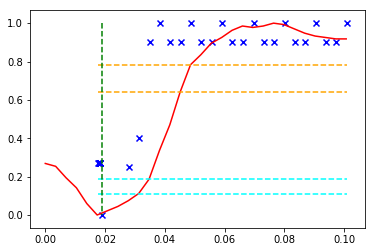

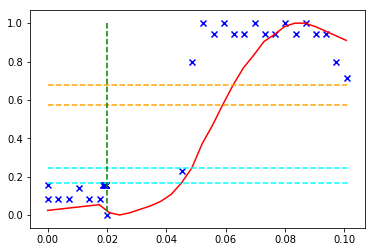

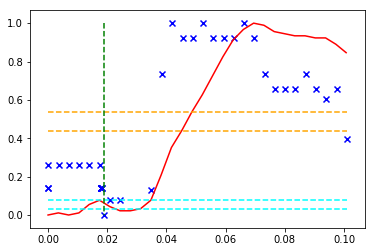

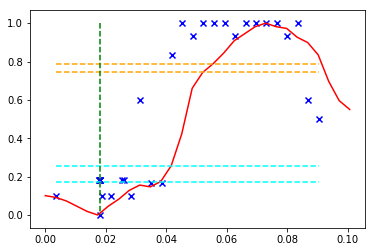

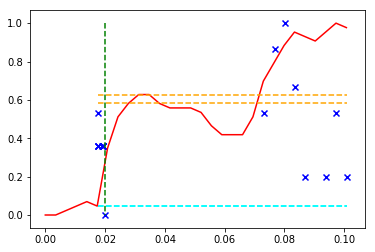

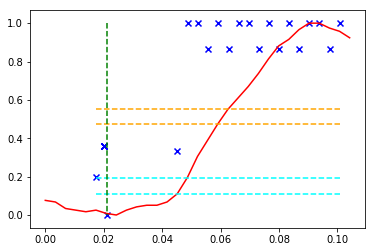

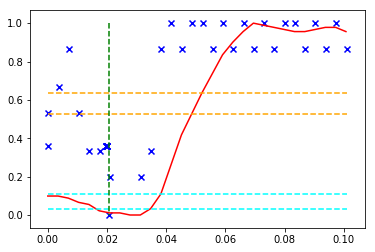

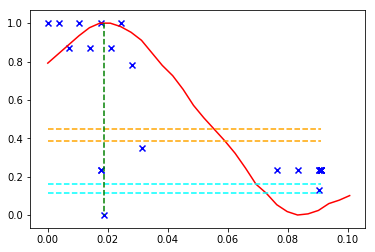

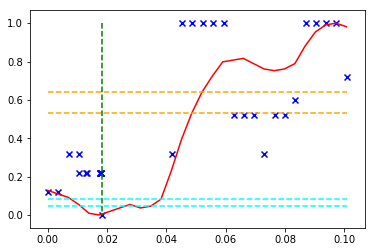

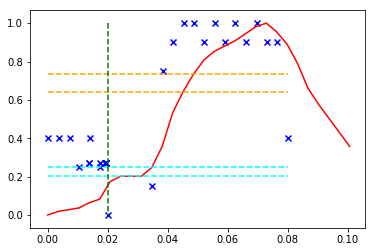

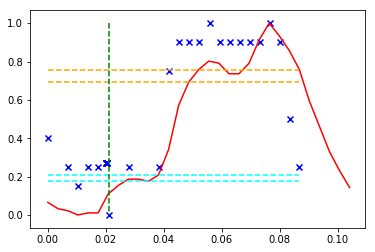

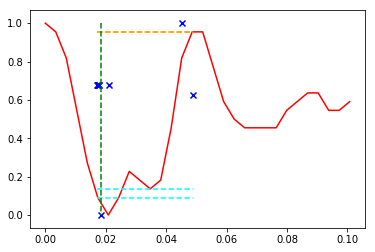

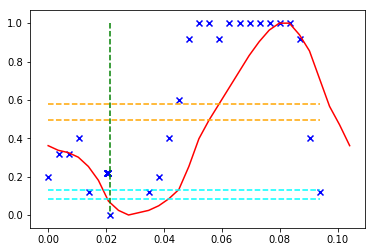

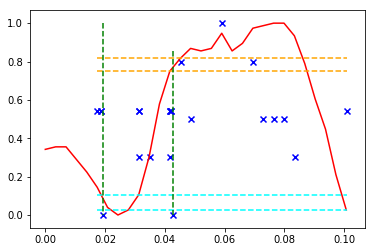

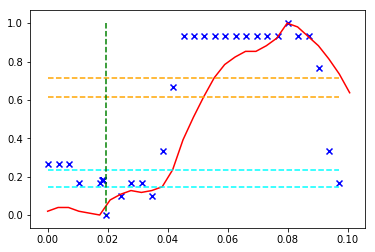

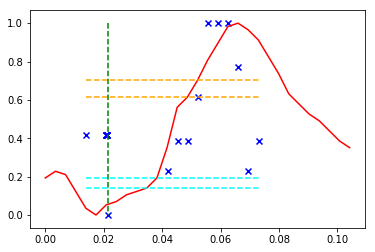

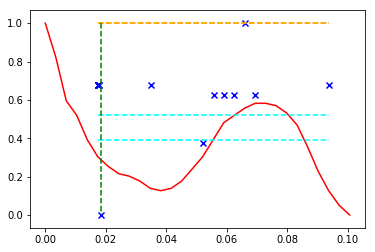

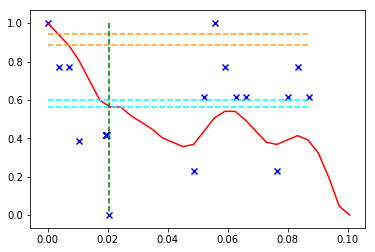

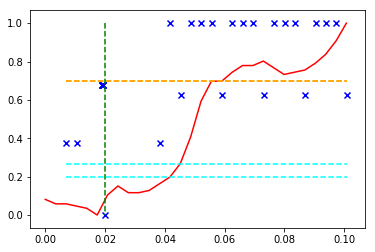

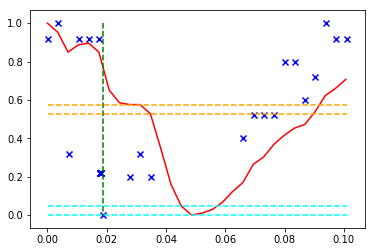

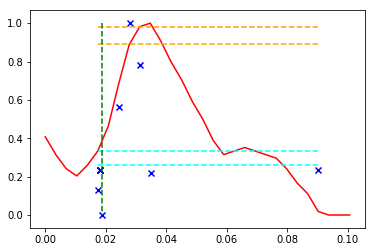

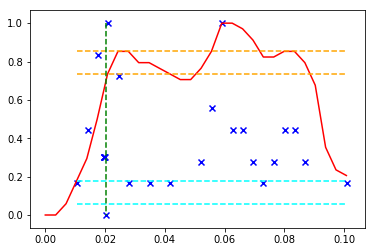

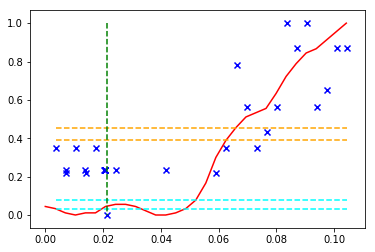

In [8]:
# Visualize
for i in range(0, len(cgmSeries_np)):
    plt.figure()
    plt.plot(cgmSeries_np[i], cgmNorm_np[i], c='red')
    plt.scatter(insulinTime_np[i], insulinBasalNorm_np[i], marker='x', c='blue')
    po1 = np.nanmin(insulinTime_np[i])
    po2 = np.nanmax(insulinTime_np[i])
    plt.plot([po1, po2], [window_mins[i][0], window_mins[i][0]], c='cyan', linestyle='dashed')
    plt.plot([po1, po2], [window_maxs[i][0], window_maxs[i][0]], c='orange', linestyle='dashed')
    plt.plot([po1, po2], [window_mins[i][1], window_mins[i][1]], c='cyan', linestyle='dashed')
    plt.plot([po1, po2], [window_maxs[i][1], window_maxs[i][1]], c='orange', linestyle='dashed')
    insulinBolusNon = insulinBolusNorm_np[i]
    insulinTimesNon = insulinTime_np[i]
    insulinTimesNon = insulinTimesNon[np.nonzero(insulinBolusNon)]
    insulinBolusNon = insulinBolusNon[np.nonzero(insulinBolusNon)]
    for j in range(0, len(insulinBolusNon)):
        plt.plot([insulinTimesNon[j], insulinTimesNon[j]], [insulinBolusNon[j], 0], c='green', linestyle='dashed')
    plt.show()

# 1.c Omkar Features

In [9]:
# series = cgmNorm_np
# datenum = cgmSeries_np
# InsulinBolus = insulinBolusNorm_np
# InsulinTimestamp = insulinTime_np

In [10]:
maximum=[]
for i in range(insulinBolusNorm_np[:,0].size):
    maximum.append(np.nanargmax(insulinBolusNorm_np[i]))
# print(maximum)

In [11]:
def slope(time,values):
    slope = []
    for i in range(len(values)-1):
        slope.append((values[i+1]-values[i])/(time[i+1]-time[i])) 
    slope.append(np.nan)
    slope = np.asarray(slope)
    
    return slope

0.5416666666666666


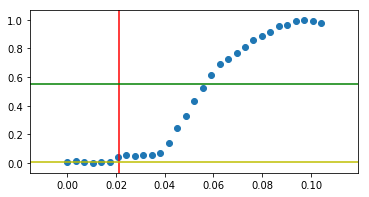

/home/omkar/.local/lib/python3.5/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice


nan


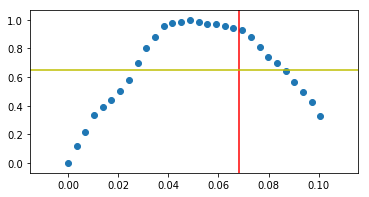

0.6940765268579838


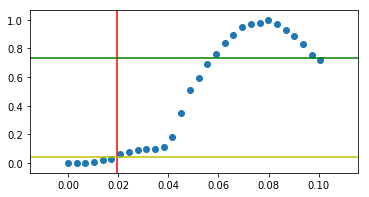

0.5816901408450704


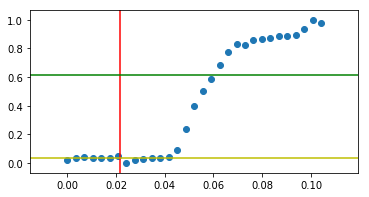

0.6164436314624049


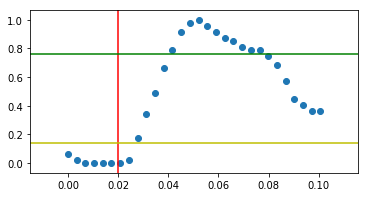

0.6261227043210151


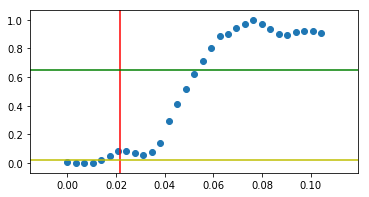

0.5585874799357945


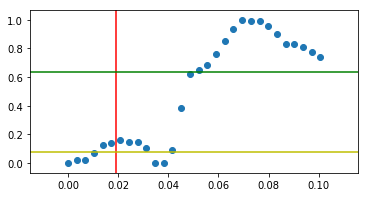

0.5741692360397397


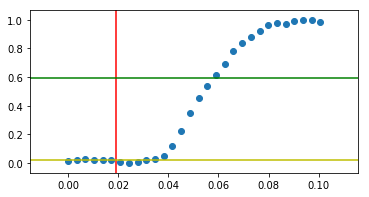

0.6294409613375131


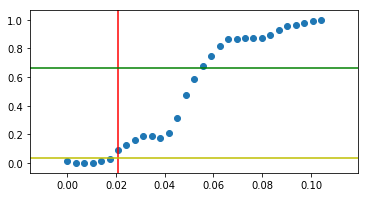

0.47790404040404044


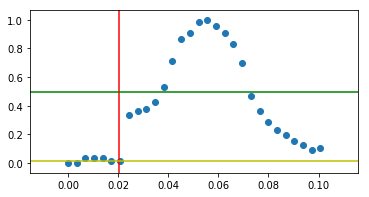

0.5228979326967648


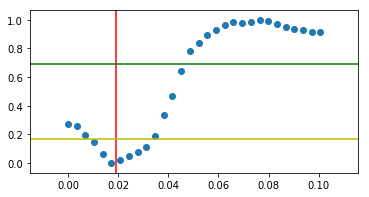

0.7540098374679214


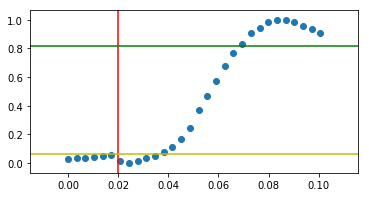

0.7803178963893251


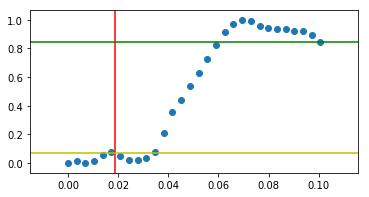

0.5194954128440368


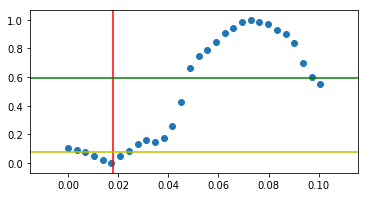

0.5069767441860464


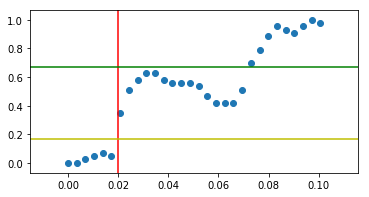

0.47620802189704176


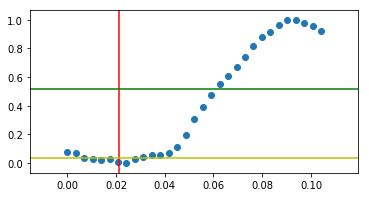

0.7728606235393566


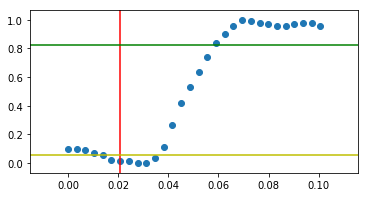

-0.46081041112097004


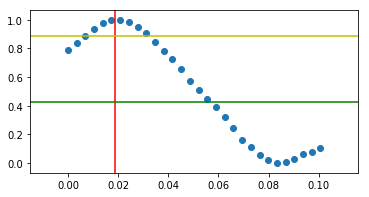

0.6811822823695463


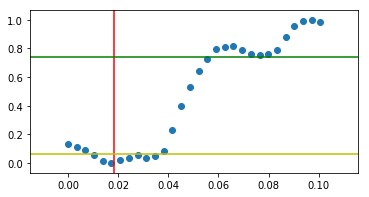

0.6085626911314985


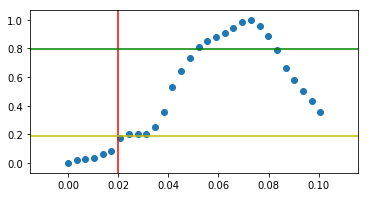

0.5712708344287291


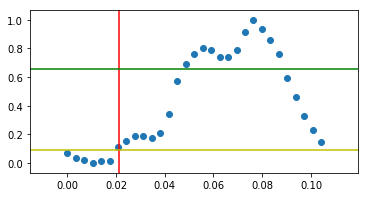

-0.2954545454545456


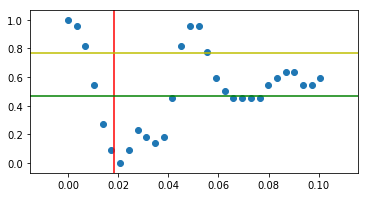

0.44059491554735697


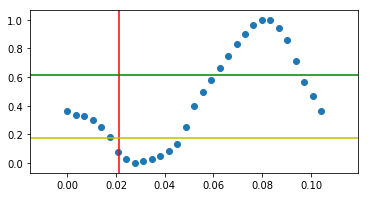

0.23731203007518775


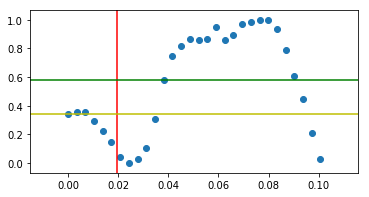

0.6424617693967538


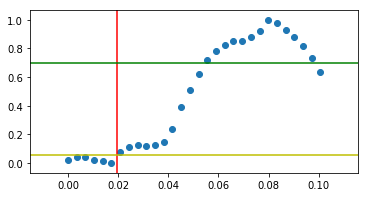

0.44644219243761574


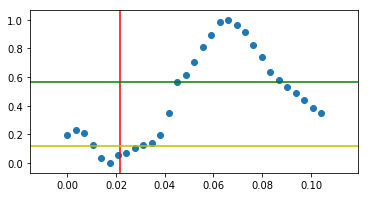

-0.399789029535865


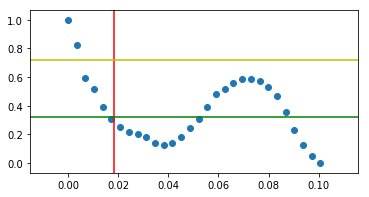

-0.342297750646208


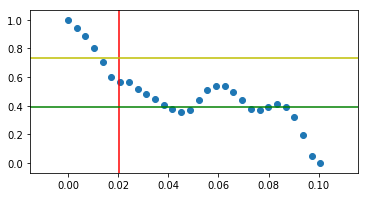

0.4952431289640591


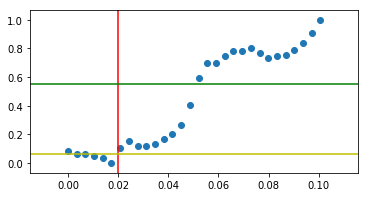

-0.4696491078289082


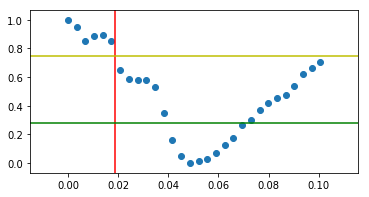

0.08760683760683763


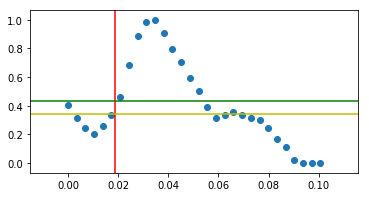

0.676470588235294


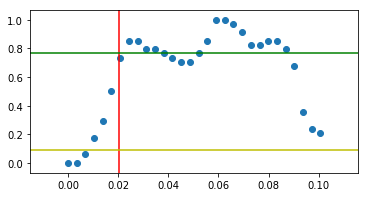

0.48939165409753643


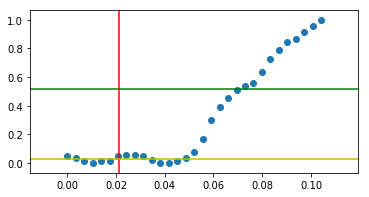

33


In [12]:
mean_before = []
mean_after = []
mean_dif = []
for i in range(0,len(cgmNorm_np)):
    fig = plt.figure(figsize=(20,3))
    
    sl = slope(cgmSeries_np[i],cgmNorm_np[i])
    
    
    sl_1 = slope(cgmSeries_np[i],sl)
    sl_2 = slope(cgmSeries_np[i],sl_1)
    sl_3 = slope(cgmSeries_np[i],sl_2)
#     cut = insulinTime_np[i,maximum[i]]
#     print(maximum[i])
#     print(cut)
#     cut1 = np.where(insulinTime_np[i]==cut)
#     print(int(cut1[0]))
#     print(cut1)
    mean1 = np.nanmean(cgmNorm_np[i][-1:-maximum[i]:-1])
    mean2 = np.nanmean(cgmNorm_np[i][-maximum[i]:0:-1])
    
    mean_before.append(mean1)
    mean_after.append(mean2)
    
    print(mean2-mean1)
    
    plt.subplot(1,3,1)
    plt.scatter(cgmSeries_np[i],cgmNorm_np[i])
    plt.axvline(x=insulinTime_np[i,maximum[i]],c='r')
    plt.axhline(y = mean1,c='y')
    plt.axhline(y = mean2,c='g')
    
#     plt.subplot(1,3,2)
#     plt.plot(cgmSeries_np[i],sl)
#     plt.axvline(x=insulinTime_np[i,maximum[i]],c='r')
#     plt.axhline(y = 0,c='y')
    
#     plt.subplot(1,3,3)
#     plt.plot(cgmSeries_np[i],sl_1)
#     plt.axvline(x=insulinTime_np[i,maximum[i]],c='r')
#     plt.axhline(y = 0,c='y')
    plt.show()

mean_dif = [x - y for x, y in zip(mean_after, mean_before)]
print(len(mean_dif))

In [13]:
 def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0)))+b
    return (y)


In [14]:
cgmSeries_np

array([[0.10416667, 0.10069444, 0.09722222, ..., 0.00694444, 0.00347222,
        0.        ],
       [0.10069444, 0.09722222, 0.09375   , ..., 0.00347222, 0.        ,
               nan],
       [0.10069444, 0.09722222, 0.09375   , ..., 0.00347222, 0.        ,
               nan],
       ...,
       [0.10069444, 0.09722222, 0.09375   , ..., 0.00347222, 0.        ,
               nan],
       [0.10071759, 0.09724537, 0.09377315, ..., 0.00347222, 0.        ,
               nan],
       [0.10416667, 0.10069444, 0.09722222, ..., 0.00694444, 0.00347222,
        0.        ]])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


22
23
24
25
26
27


/home/omkar/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


28
29
30
31
32


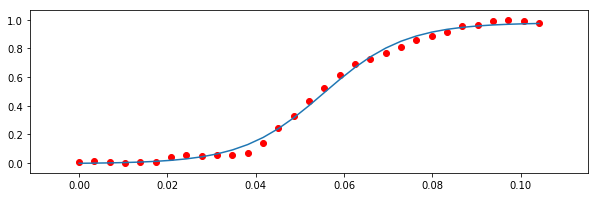

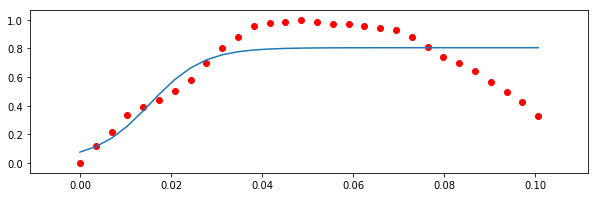

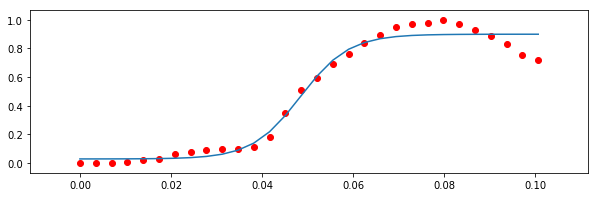

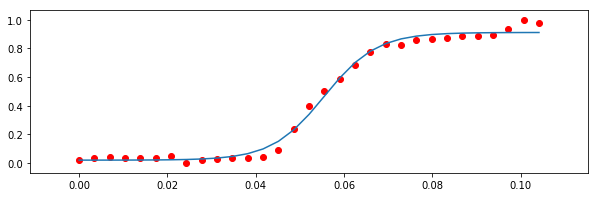

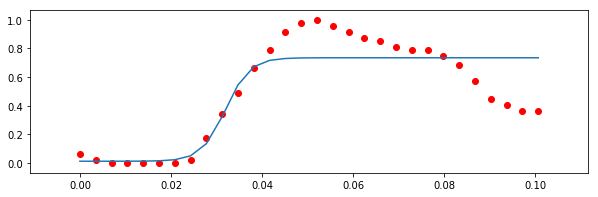

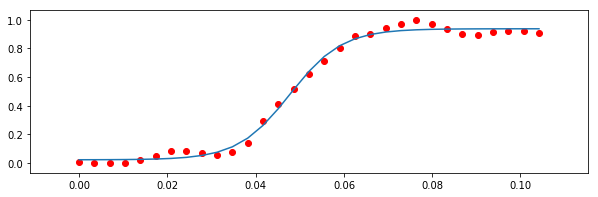

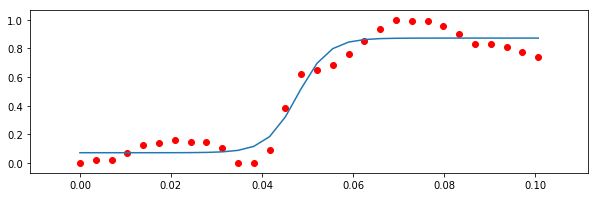

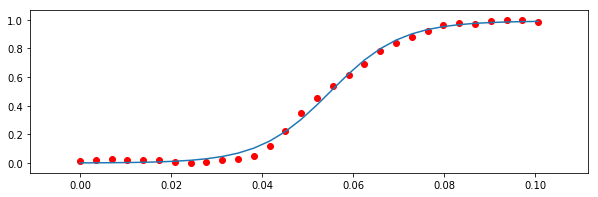

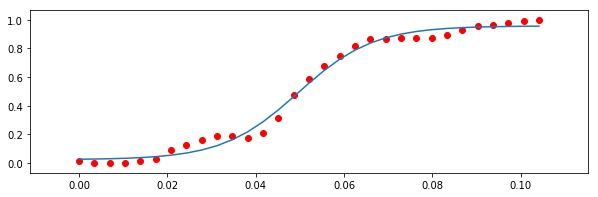

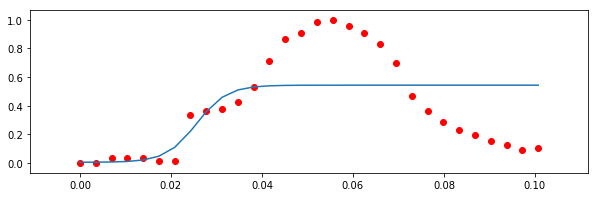

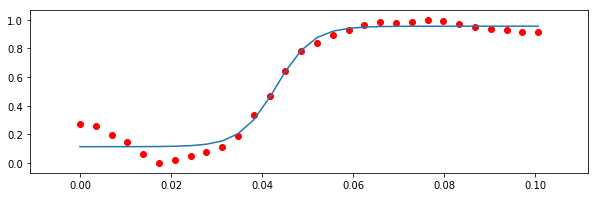

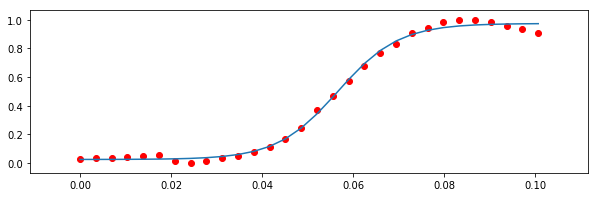

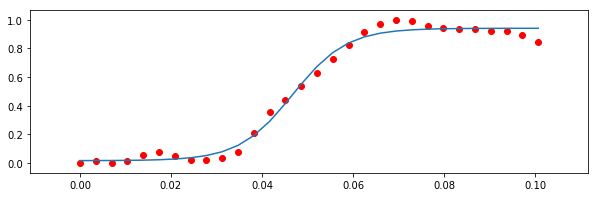

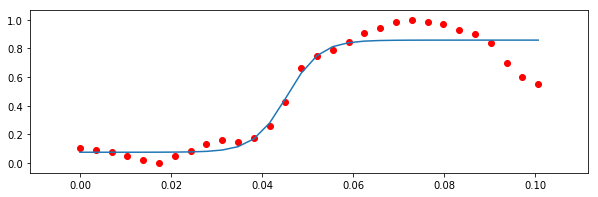

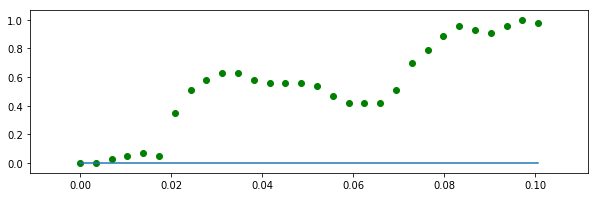

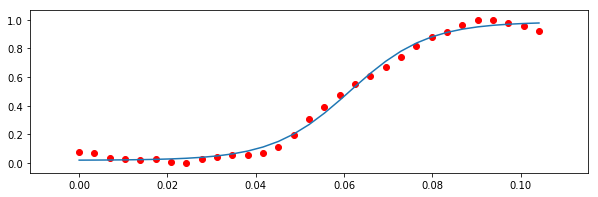

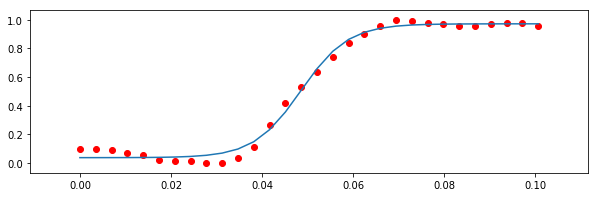

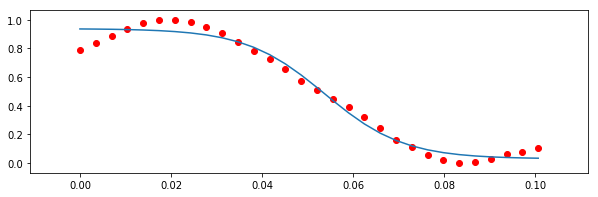

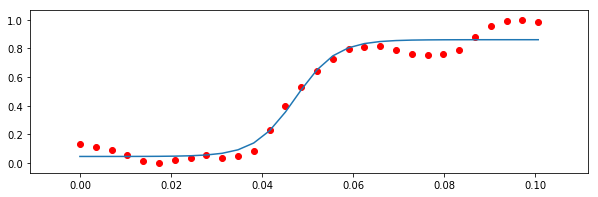

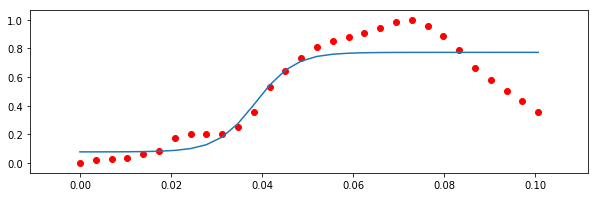

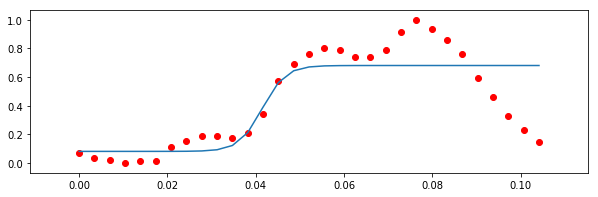

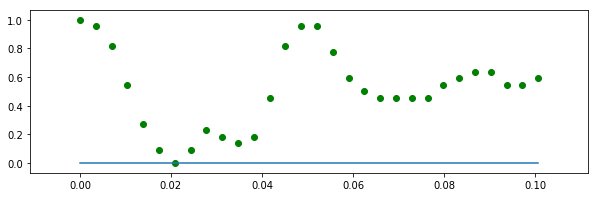

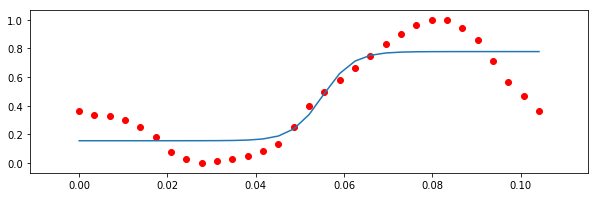

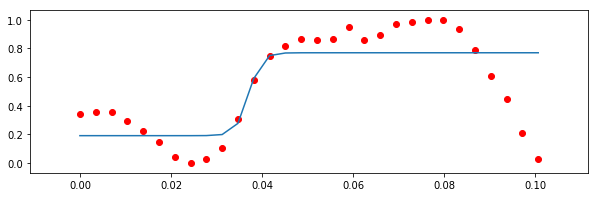

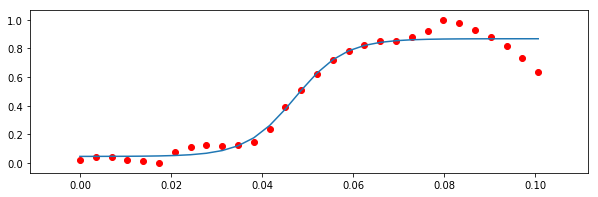

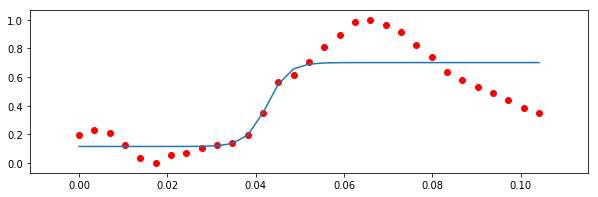

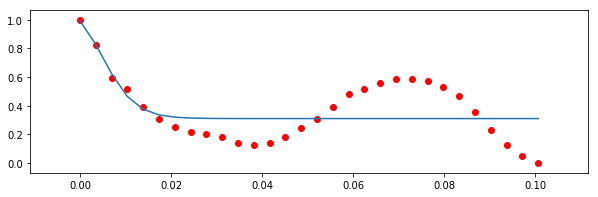

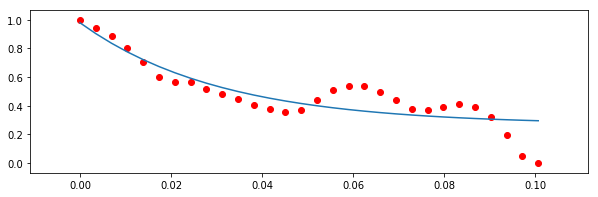

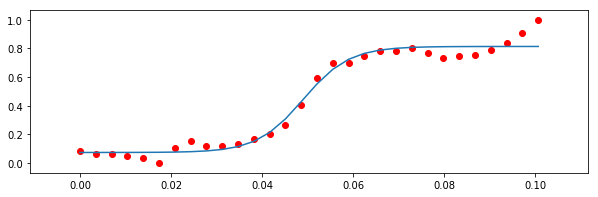

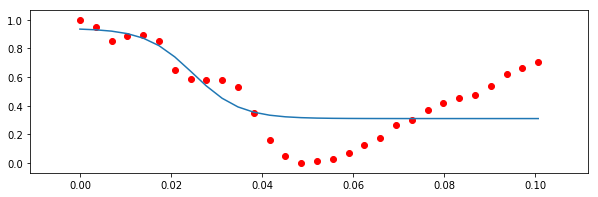

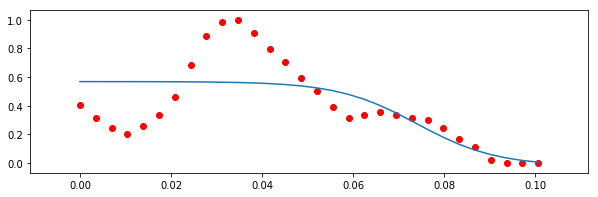

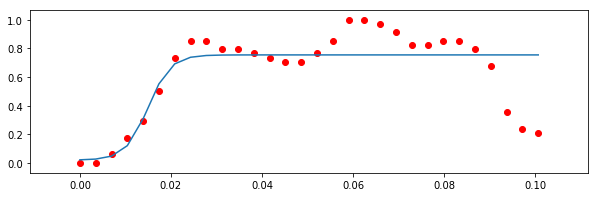

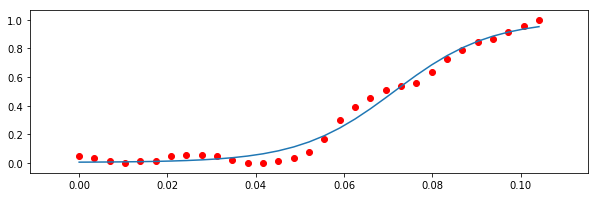

33

In [15]:
from scipy.optimize import curve_fit

from matplotlib import pyplot as plt
n_series = []
n_datenum = []
sig1 = []
sig2 = []
sig3 = []
sig4 = []
#print(cgmSeries_np.shape[0])
for i in range(cgmNorm_np.shape[0]):
    #print(cgmSeries_np[i])
    
    idx = np.isfinite(cgmSeries_np[i]) & np.isfinite(cgmNorm_np[i])
    #print(idx)
    n_series.append(cgmNorm_np[i][idx])  
    n_datenum.append(cgmSeries_np[i][idx])


#print(n_series)

for i in range(0,len(cgmNorm_np)):
    print(i)
    
    #print(len(n_series[i]))
    if(len(n_series[i]) !=0 ):
        try:
            fig = plt.figure(figsize=(10,3))
            p0 = [max(n_series[i]), np.median(n_datenum[i]),250,min(n_series[i])] 

            popt, pcov = curve_fit(sigmoid, n_datenum[i], n_series[i],p0,method='trf')
            plt.scatter(n_datenum[i],n_series[i],c='r')
            plt.plot(n_datenum[i],sigmoid(n_datenum[i],*popt))
            
   

            
        except: 
            plt.scatter(n_datenum[i],n_series[i],c='g')
            popt=[0,0,0,0]
            plt.plot(n_datenum[i],sigmoid(n_datenum[i],*popt))
        
        sig1.append(popt[0])
        sig2.append(popt[1])
        sig3.append(popt[2])
        sig4.append(popt[3])



plt.show()
len(sig1)


In [16]:
len(sig4)

33

# 1.d Ananth Features

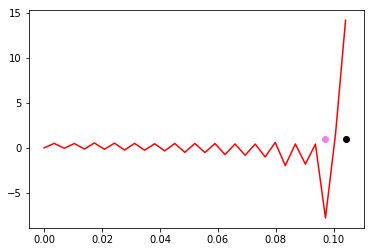

[14.152941176470591, -7.79180485872869, 0.1829278452159737, 8.896929188242058]


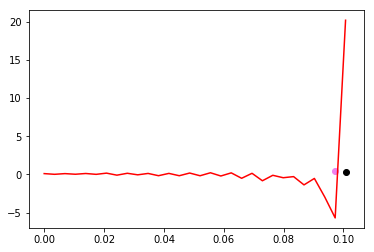

[20.2, -5.705957551777416, 0.2628243748125339, 14.552350844796294]


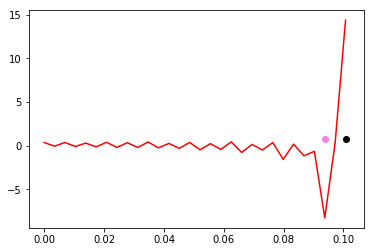

[14.357615894039736, -8.252658531102163, 0.1310711632757856, 9.062951244246785]


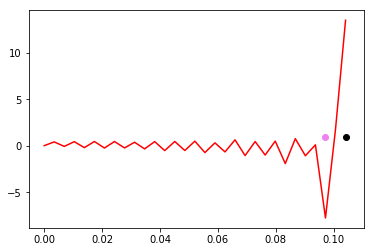

[13.521126760563382, -7.737259637951441, 0.1929759859978857, 8.274060830032717]


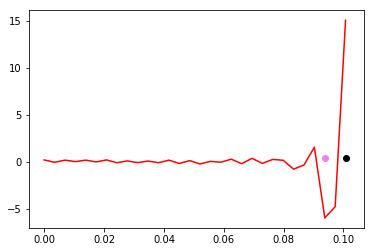

[15.063829787234036, -5.980068671572691, 0.1861416483262577, 9.299395300251561]


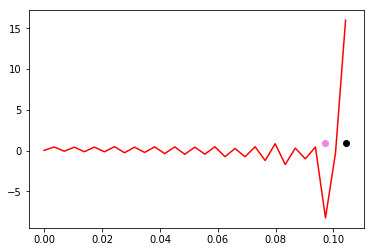

[15.985611510791369, -8.253866169424075, 0.20302508965366958, 10.734341752012881]


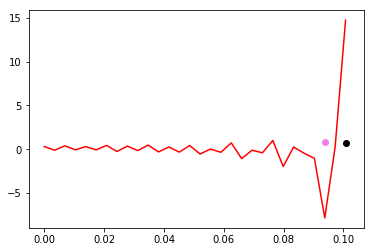

[14.719101123595504, -7.833855632170877, 0.1589898491539232, 9.265724911626203]


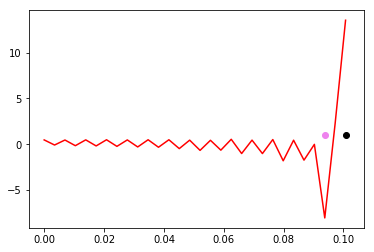

[13.546762589928058, -8.04421424055926, 0.1735090552018789, 8.556563634110683]


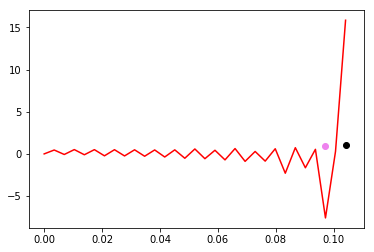

[15.839080459770118, -7.581522380154777, 0.23032631324794225, 10.372258455077953]


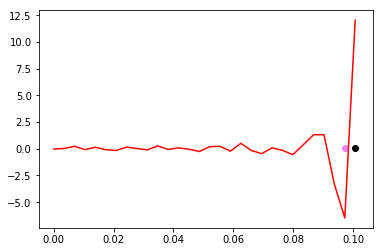

[12.030303030303031, -6.473668542026381, 0.1576539300092298, 6.510343259621045]


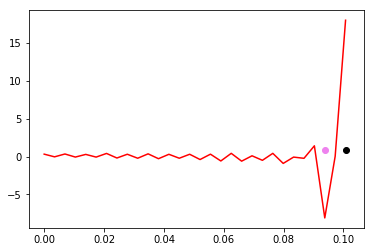

[18.029850746268657, -8.12147926407745, 0.34633296697722915, 12.673942121347247]


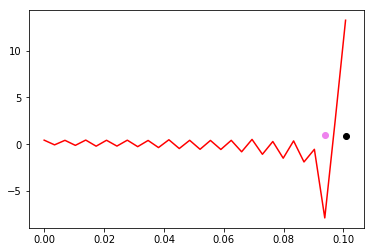

[13.251497005988021, -7.866720978916915, 0.15912330501647123, 8.203276087065548]


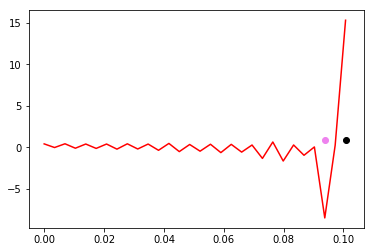

[15.285714285714286, -8.492242566966594, 0.16367735210623455, 10.130226759127467]


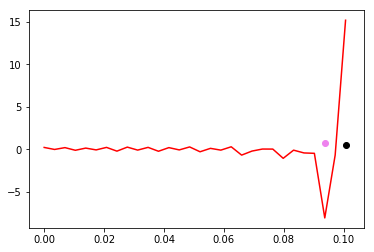

[15.174311926605505, -8.043779440527064, 0.15769413761479248, 9.591701165384217]


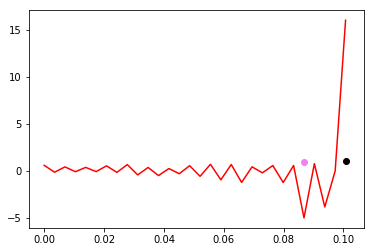

[16.0, -5.02394001566111, 0.25881366388760724, 9.779732980711891]


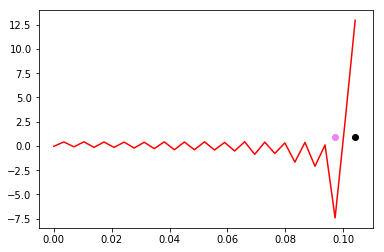

[12.966101694915253, -7.420973533258622, 0.17356033580106633, 7.75308936462714]


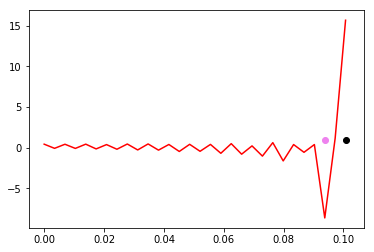

[15.692307692307695, -8.659112889596326, 0.2307339441431879, 10.624707085050446]


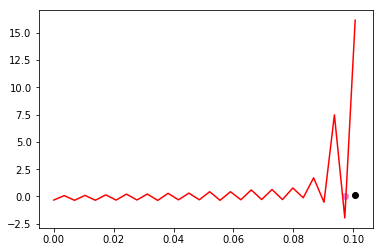

[16.160714285714285, -1.969178368142871, 0.7446833277324251, 10.011285240775608]


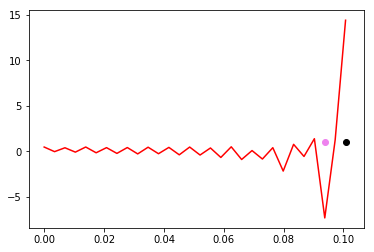

[14.403669724770642, -7.34419384540439, 0.2521718838162667, 8.811794545364311]


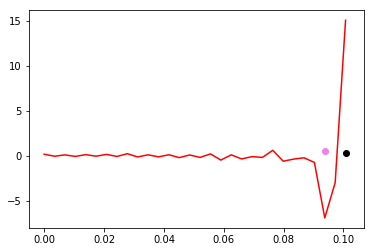

[15.064220183486242, -6.888313780972571, 0.11558314187666195, 9.191969729219679]


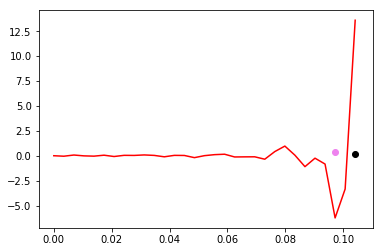

[13.60439560439561, -6.244686168346047, 0.08797222240392898, 7.689527464118289]


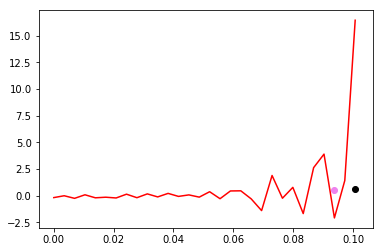

[16.454545454545446, -2.077440717102524, 0.7026666272495861, 9.486864782903822]


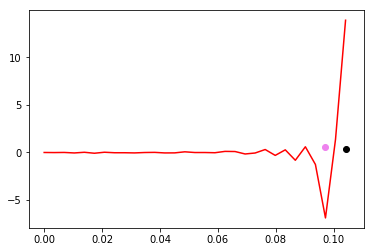

[13.891566265060245, -6.885453526229257, 0.21745697103816078, 7.86410463371923]


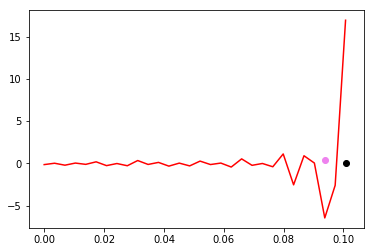

[16.934210526315788, -6.451889345144363, 0.1946257165006794, 11.091471424704098]


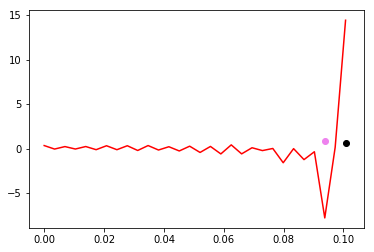

[14.421568627450984, -7.804309871308283, 0.11225137531167996, 8.864481644342577]


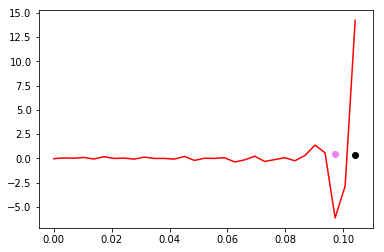

[14.228070175438594, -6.135902229765284, 0.21861939292538562, 8.051590979875483]


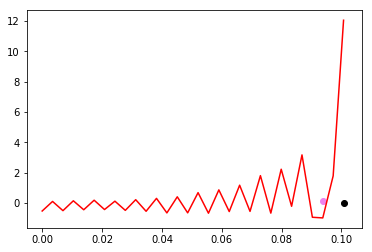

[12.050632911392409, -0.9804584462324256, 0.533028729738856, 5.373756747509949]


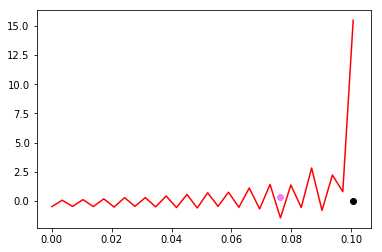

[15.471264367816094, -1.44650488592687, 0.6487974518057343, 8.158164232292261]


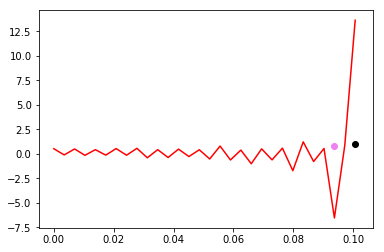

[13.639534883720929, -6.552731330831548, 0.28272494955780453, 7.690334751329993]


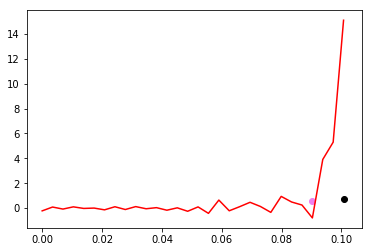

[15.10377358490566, -0.7903097782357722, 0.8092019572152174, 8.202209957916388]


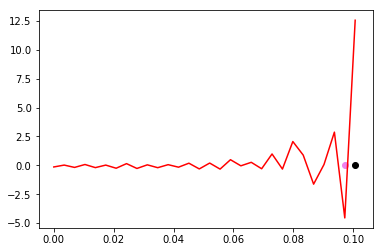

[12.555555555555552, -4.549071616140221, 0.38940693742973864, 6.1817840699060485]


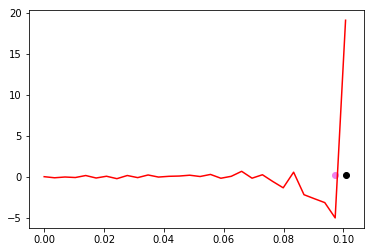

[19.088235294117652, -4.987069732554668, 0.20965807933263342, 13.311635631750686]


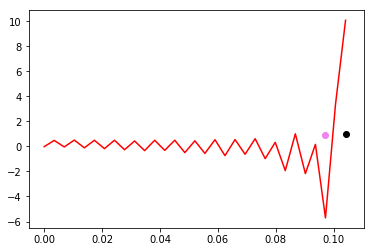

[10.088888888888889, -5.712856683267215, 0.19684984294871988, 5.155300318542535]


[[14.152941176470591,
  -7.79180485872869,
  0.1829278452159737,
  8.896929188242058],
 [20.2, -5.705957551777416, 0.2628243748125339, 14.552350844796294],
 [14.357615894039736,
  -8.252658531102163,
  0.1310711632757856,
  9.062951244246785],
 [13.521126760563382,
  -7.737259637951441,
  0.1929759859978857,
  8.274060830032717],
 [15.063829787234036,
  -5.980068671572691,
  0.1861416483262577,
  9.299395300251561],
 [15.985611510791369,
  -8.253866169424075,
  0.20302508965366958,
  10.734341752012881],
 [14.719101123595504,
  -7.833855632170877,
  0.1589898491539232,
  9.265724911626203],
 [13.546762589928058,
  -8.04421424055926,
  0.1735090552018789,
  8.556563634110683],
 [15.839080459770118,
  -7.581522380154777,
  0.23032631324794225,
  10.372258455077953],
 [12.030303030303031,
  -6.473668542026381,
  0.1576539300092298,
  6.510343259621045],
 [18.029850746268657,
  -8.12147926407745,
  0.34633296697722915,
  12.673942121347247],
 [13.251497005988021,
  -7.866720978916915,
  0.

In [17]:
Feature_vector=[]
for i in range(0, len(cgmSeries_np)):
#FFT
    fastfouriertransform=rfft(cgmNorm_np[i])
    plt.figure()
    plt.plot(cgmSeries_np[i], fastfouriertransform, c='red')
    fft_max=np.nanmax(fastfouriertransform)
    s=np.where(fastfouriertransform == fft_max)
    plt.scatter(cgmSeries_np[i][s],cgmNorm_np[i][s], c='black')
    fft_min=np.nanmin(fastfouriertransform)
    s=np.where(fastfouriertransform == fft_min)
    plt.scatter(cgmSeries_np[i][s],cgmNorm_np[i][s], c='violet')
    fft_mean=np.nanmean(fastfouriertransform)
    fft_variance=np.nanvar(fastfouriertransform)
    Feature_vector.append([fft_max,fft_min,fft_mean,fft_variance])
    plt.show()
    print([fft_max,fft_min,fft_mean,fft_variance])
display(Feature_vector)   

# 2. Generating Feature Matrix

In [18]:
# Feature Matrix
matrix = []
for i in range(0, len(cgmSeries_np)):
    matrix_row = np.array([])
    # Anirudh
    matrix_row = np.append(matrix_row, slopes[i])
    matrix_row = np.append(matrix_row, time_diffs[i])
    matrix_row = np.append(matrix_row, peak_values[i])
    matrix_row = np.append(matrix_row, peak_heights[i])
    matrix_row = np.append(matrix_row, peak_times[i])
    # Vedant
    matrix_row = np.append(matrix_row, window_mins[i])
    matrix_row = np.append(matrix_row, window_maxs[i])
    matrix_row = np.append(matrix_row, window_vars[i])
    matrix_row = np.append(matrix_row, window_means[i])
    # Omkar
    matrix_row = np.append(matrix_row, mean_before[i])
    matrix_row = np.append(matrix_row, mean_after[i])
    matrix_row = np.append(matrix_row, mean_dif[i])
    matrix_row = np.append(matrix_row, sig1[i])
    matrix_row = np.append(matrix_row, sig2[i])
    matrix_row = np.append(matrix_row, sig3[i])
    matrix_row = np.append(matrix_row, sig4[i])
    
    # Ananth
    matrix_row = np.append(matrix_row, Feature_vector[i])
    if len(matrix) == 0:
        matrix = np.array([matrix_row])
    else:
        matrix = np.append(matrix, [matrix_row], axis=0)
       
matrix = np.nan_to_num(matrix)
# Normalizing Values
# print(np.nan_to_num(np.log(np.nan)))
means = np.mean(matrix, axis=0)
mean_great = np.argwhere(means > 1).flatten()
mean_small = np.argwhere(means < -1).flatten()
# for i in mean_great:
#     print(i)
#     matrix[i][:] = np.nan_to_num(np.log(matrix[i][:]))
# transformer = pre.FunctionTransformer(np.log1p, validate=True)
# matrix = transformer.transform(matrix)
# matrix = np.nan_to_num(matrix)

In [19]:
# Converting to dataframe for easy visualization
columns = np.array(['Slope_minmax', 'TimeDiff_minmax', 
           'PeakVal1_error', 'PeakVal2_error', 'PeakHt1_error', 'PeakHt2_error', 'PeakTime1_error', 'PeakTime2_error', 
           'Min1_window', 'Min2_window', 'Max1_window', 'Max2_window', 'Var1_window', 'Var2_window', 'Mean1_window', 'Mean2_window', 
           'Mean_before', 'Mean_after', 'Mean_diff','Sig_coef1','Sig_coef2','Sig_coef3','Sig_coef4',
           'Max_fft', 'Min_fft', 'Mean_fft', 'Var_fft'
          ])
feature_df = pd.DataFrame(matrix, columns=columns)
for i in mean_great:
    feature_df[columns[i]] = np.nan_to_num(np.log10(feature_df[columns[i]].replace(0, np.nan)))
for i in mean_small:
    feature_df[columns[i]] = np.sign(feature_df[columns[i]])*np.nan_to_num(np.log10(np.abs(feature_df[columns[i]].replace(0, np.nan))))
    #     print()
display(feature_df)
feature_df.to_csv('Features_'+str(patient)+'.csv')

/home/omkar/.local/lib/python3.5/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log10
  # Remove the CWD from sys.path while we load stuff.


,Slope_minmax,TimeDiff_minmax,PeakVal1_error,PeakVal2_error,PeakHt1_error,PeakHt2_error,PeakTime1_error,PeakTime2_error,Min1_window,Min2_window,...,Mean_after,Mean_diff,Sig_coef1,Sig_coef2,Sig_coef3,Sig_coef4,Max_fft,Min_fft,Mean_fft,Var_fft
0,1.061452,0.086806,0.041176,0.611765,0.045098,0.080392,0.020833,0.059028,0.135294,0.241176,...,0.547549,0.541667,-0.006429,0.055377,2.032806,0.000000,1.150847,-0.891638,0.182928,0.949240
1,1.313264,0.048611,0.214815,0.881481,0.113580,0.128395,0.006944,0.034722,0.000000,0.503704,...,0.000000,0.000000,-0.106108,0.015409,2.230537,-1.671325,1.305351,-0.756329,0.262824,1.162933
2,1.137173,0.072917,0.980132,0.350993,0.107064,0.149007,0.076389,0.045139,0.112583,0.178808,...,0.732156,0.694077,-0.059349,0.048462,2.274180,-1.574061,1.157082,-0.916594,0.131071,0.957270
3,1.116970,0.076389,0.239437,0.683099,0.116197,0.151408,0.048611,0.062500,0.091549,0.042254,...,0.611972,0.581690,-0.049217,0.055527,2.227617,-1.737600,1.131013,-0.888587,0.192976,0.917719
4,1.505150,0.031250,0.787234,0.914894,0.134752,0.223404,0.076389,0.045139,0.021277,0.170213,...,0.757196,0.616444,-0.140480,0.031986,2.576952,-1.973442,1.177935,-0.776706,0.186142,0.968455
5,1.180639,0.065972,0.805755,0.971223,0.110312,0.123501,0.059028,0.072917,0.136691,0.071942,...,0.648733,0.626123,-0.037987,0.047762,2.228609,-1.682655,1.203729,-0.916657,0.203025,1.030775
6,1.505150,0.031250,0.932584,0.382022,0.155431,0.460674,0.065984,0.045150,0.000000,0.000000,...,0.633494,0.558587,-0.095993,0.047812,2.470496,-1.153720,1.167881,-0.893976,0.158990,0.966879
7,1.137173,0.072917,0.690647,0.920863,0.080336,0.082734,0.062500,0.076389,0.115108,0.050360,...,0.590956,0.574169,-0.003004,0.054944,2.108200,0.000000,1.131836,-0.905484,0.173509,0.932299
8,1.028029,0.093750,0.816092,0.471264,0.101533,0.118774,0.062500,0.048611,0.206897,0.172414,...,0.662487,0.629441,-0.029197,0.049594,2.068594,-1.659415,1.199730,-0.879756,0.230326,1.015873
9,1.283012,0.052118,0.909091,0.333333,0.257576,0.282828,0.062535,0.024306,0.363636,0.287879,...,0.493056,0.477904,-0.268294,0.025613,2.474564,-2.465435,1.080277,-0.811150,0.157654,0.813604


# Visualizing Spread and PCA (Skip here if you want to run only PCA)

In [20]:
columns = np.array(['Slope_minmax', 'TimeDiff_minmax', 
           'PeakVal1_error', 'PeakVal2_error', 'PeakHt1_error', 'PeakHt2_error', 'PeakTime1_error', 'PeakTime2_error', 
           'Min1_window', 'Min2_window', 'Max1_window', 'Max2_window', 'Var1_window', 'Var2_window', 'Mean1_window', 'Mean2_window', 
           'Mean_before', 'Mean_after', 'Mean_diff','Sig_coef1','Sig_coef2','Sig_coef3','Sig_coef4',
           'Max_fft', 'Min_fft', 'Mean_fft', 'Var_fft'
          ])
feature_df = pd.read_csv('Features_'+str(patient)+'.csv')
feature_df = feature_df.drop(feature_df.columns[0], axis=1)
display(feature_df)

,Slope_minmax,TimeDiff_minmax,PeakVal1_error,PeakVal2_error,PeakHt1_error,PeakHt2_error,PeakTime1_error,PeakTime2_error,Min1_window,Min2_window,...,Mean_after,Mean_diff,Sig_coef1,Sig_coef2,Sig_coef3,Sig_coef4,Max_fft,Min_fft,Mean_fft,Var_fft
0,1.061452,0.086806,0.041176,0.611765,0.045098,0.080392,0.020833,0.059028,0.135294,0.241176,...,0.547549,0.541667,-0.006429,0.055377,2.032806,0.000000,1.150847,-0.891638,0.182928,0.949240
1,1.313264,0.048611,0.214815,0.881481,0.113580,0.128395,0.006944,0.034722,0.000000,0.503704,...,0.000000,0.000000,-0.106108,0.015409,2.230537,-1.671325,1.305351,-0.756329,0.262824,1.162933
2,1.137173,0.072917,0.980132,0.350993,0.107064,0.149007,0.076389,0.045139,0.112583,0.178808,...,0.732156,0.694077,-0.059349,0.048462,2.274180,-1.574061,1.157082,-0.916594,0.131071,0.957270
3,1.116970,0.076389,0.239437,0.683099,0.116197,0.151408,0.048611,0.062500,0.091549,0.042254,...,0.611972,0.581690,-0.049217,0.055527,2.227617,-1.737600,1.131013,-0.888587,0.192976,0.917719
4,1.505150,0.031250,0.787234,0.914894,0.134752,0.223404,0.076389,0.045139,0.021277,0.170213,...,0.757196,0.616444,-0.140480,0.031986,2.576952,-1.973442,1.177935,-0.776706,0.186142,0.968455
5,1.180639,0.065972,0.805755,0.971223,0.110312,0.123501,0.059028,0.072917,0.136691,0.071942,...,0.648733,0.626123,-0.037987,0.047762,2.228609,-1.682655,1.203729,-0.916657,0.203025,1.030775
6,1.505150,0.031250,0.932584,0.382022,0.155431,0.460674,0.065984,0.045150,0.000000,0.000000,...,0.633494,0.558587,-0.095993,0.047812,2.470496,-1.153720,1.167881,-0.893976,0.158990,0.966879
7,1.137173,0.072917,0.690647,0.920863,0.080336,0.082734,0.062500,0.076389,0.115108,0.050360,...,0.590956,0.574169,-0.003004,0.054944,2.108200,0.000000,1.131836,-0.905484,0.173509,0.932299
8,1.028029,0.093750,0.816092,0.471264,0.101533,0.118774,0.062500,0.048611,0.206897,0.172414,...,0.662487,0.629441,-0.029197,0.049594,2.068594,-1.659415,1.199730,-0.879756,0.230326,1.015873
9,1.283012,0.052118,0.909091,0.333333,0.257576,0.282828,0.062535,0.024306,0.363636,0.287879,...,0.493056,0.477904,-0.268294,0.025613,2.474564,-2.465435,1.080277,-0.811150,0.157654,0.813604


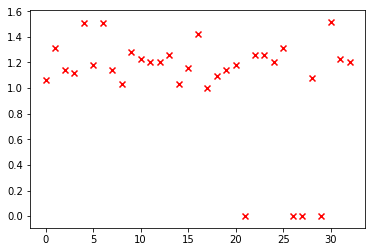

<Figure size 432x288 with 0 Axes>

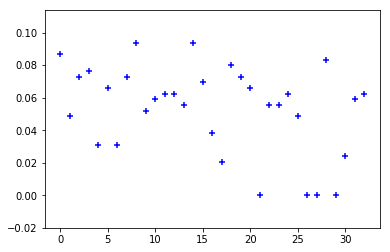

<Figure size 432x288 with 0 Axes>

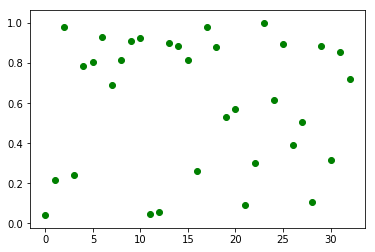

<Figure size 432x288 with 0 Axes>

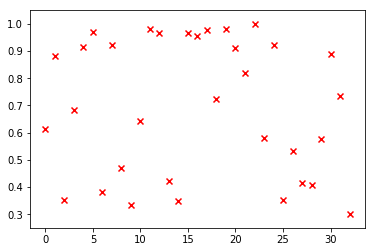

<Figure size 432x288 with 0 Axes>

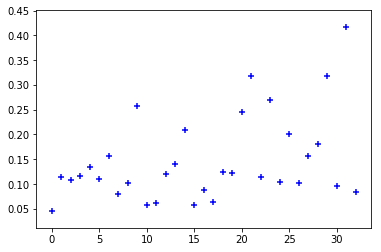

<Figure size 432x288 with 0 Axes>

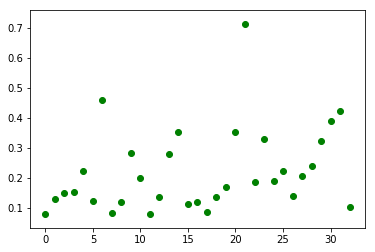

<Figure size 432x288 with 0 Axes>

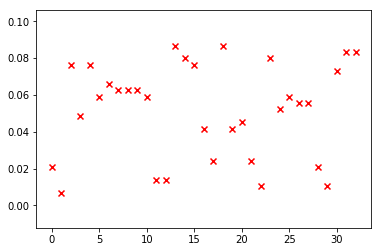

<Figure size 432x288 with 0 Axes>

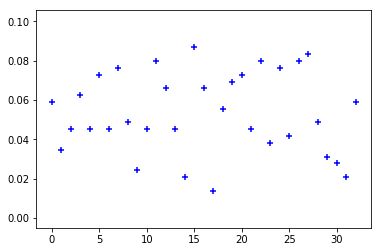

<Figure size 432x288 with 0 Axes>

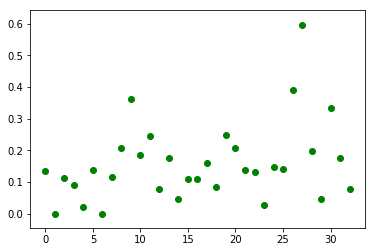

<Figure size 432x288 with 0 Axes>

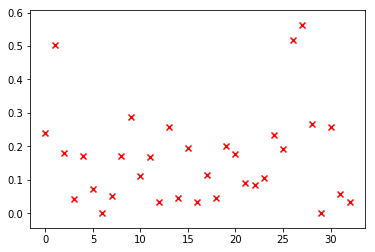

<Figure size 432x288 with 0 Axes>

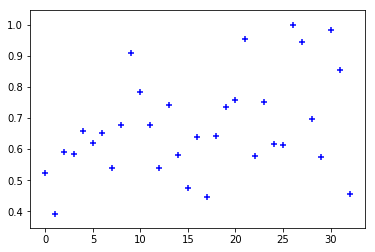

<Figure size 432x288 with 0 Axes>

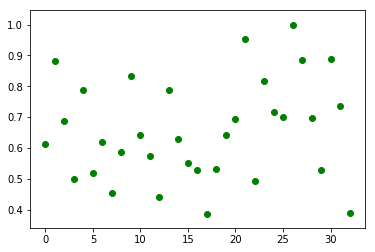

<Figure size 432x288 with 0 Axes>

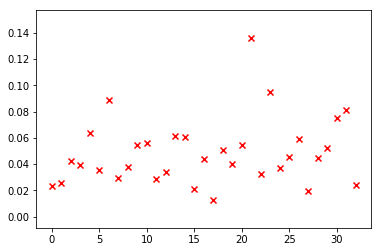

<Figure size 432x288 with 0 Axes>

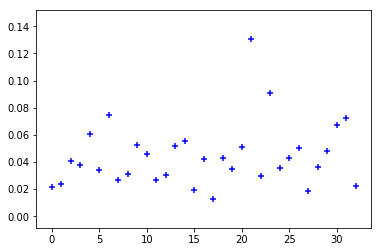

<Figure size 432x288 with 0 Axes>

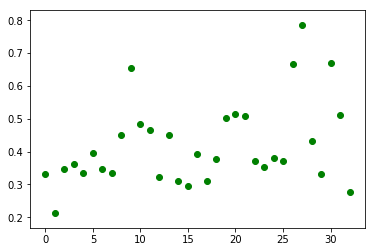

<Figure size 432x288 with 0 Axes>

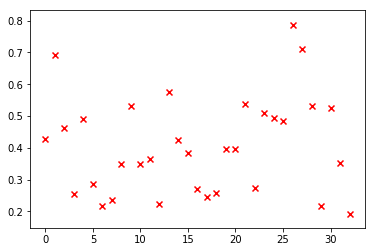

<Figure size 432x288 with 0 Axes>

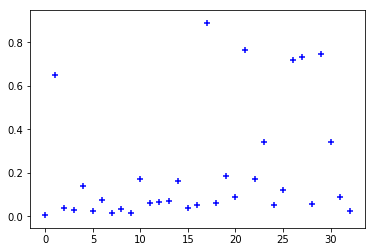

<Figure size 432x288 with 0 Axes>

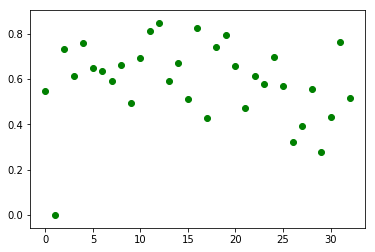

<Figure size 432x288 with 0 Axes>

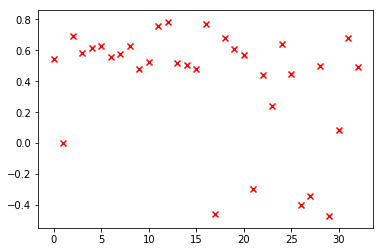

<Figure size 432x288 with 0 Axes>

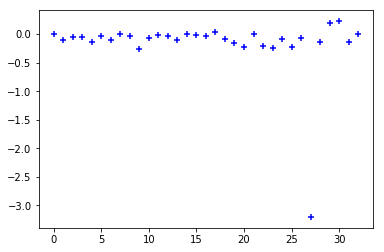

<Figure size 432x288 with 0 Axes>

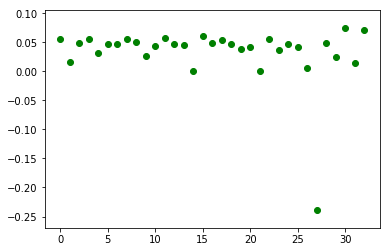

<Figure size 432x288 with 0 Axes>

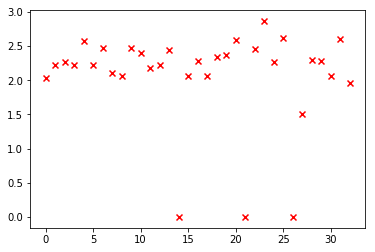

<Figure size 432x288 with 0 Axes>

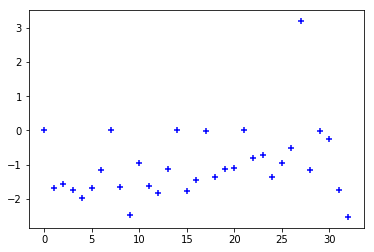

<Figure size 432x288 with 0 Axes>

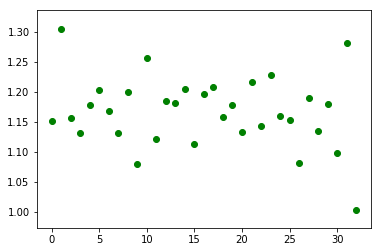

<Figure size 432x288 with 0 Axes>

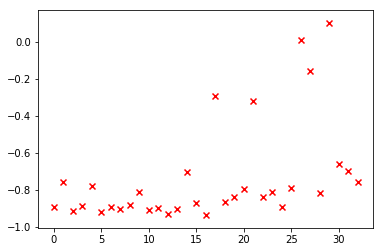

<Figure size 432x288 with 0 Axes>

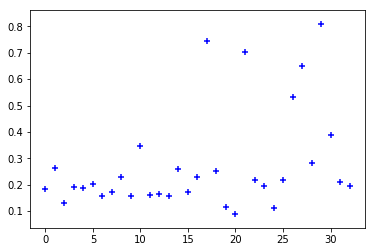

<Figure size 432x288 with 0 Axes>

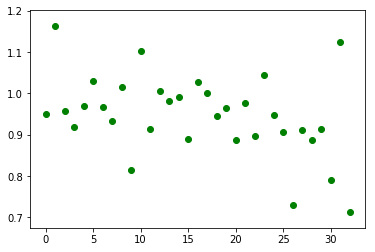

<Figure size 432x288 with 0 Axes>

In [25]:
matrix = feature_df.values
means = np.mean(matrix, axis=0)
# print(means)
# Scatter Visualization
rows = [i for i in range(len(cgmNorm_np))]
colors = ['red', 'blue', 'green']
markers = ['x', '+', 'o']
for i in range(0, matrix.shape[1]):
    plt.figure()
    plt.scatter(rows, matrix[:, i], color=colors[i%3] ,marker=markers[i%3])
    plt.show()
    # Save Images
    plt.savefig('Images/Patient' + str(patient) + '/' + columns[i] + '.png')

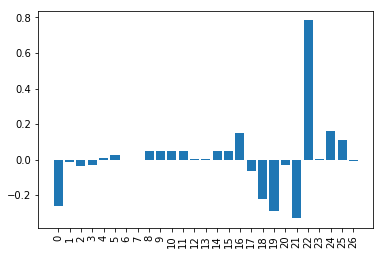

<Figure size 432x288 with 0 Axes>

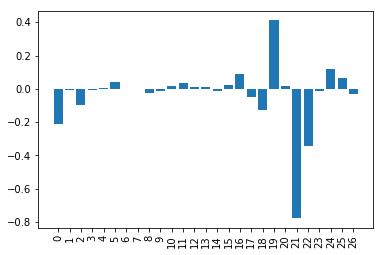

<Figure size 432x288 with 0 Axes>

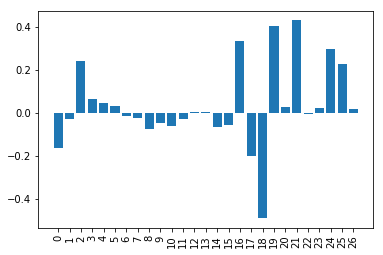

<Figure size 432x288 with 0 Axes>

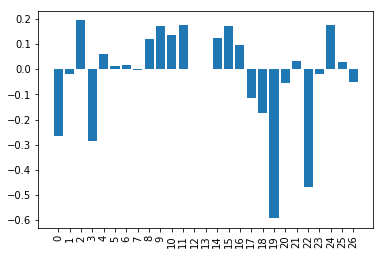

<Figure size 432x288 with 0 Axes>

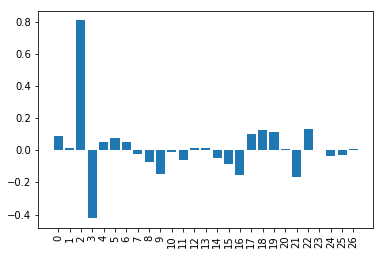

<Figure size 432x288 with 0 Axes>

In [22]:
# PCA
pca = PCA(n_components=5)
pca.fit(matrix)
components = pca.components_
variances = pca.explained_variance_
x = [i for i in range(0, len(components[0]))]
for i in range(0, 5):
    plt.figure()
    plt.bar(x, components[i])
    plt.xticks(np.arange(len(components[0])), x, rotation=90)
    plt.show()
    positives = np.array(np.argwhere(components[i] > 0).flatten())
    positive_sorted = np.argsort(components[i][:])
    positives = positive_sorted
#     print(components[i])
#     print(positives)
#     print(columns)
#     print(variances[i])
#     print(columns[positives])
#     print(components[i][positives])
    plt.savefig('Images/Patient' + str(patient) + '/' + 'PCA' + str(i) + '.png')
#     print(components[i])

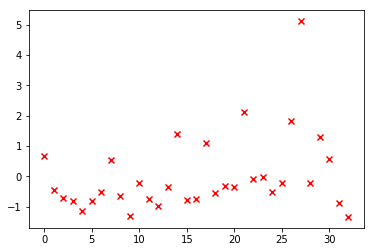

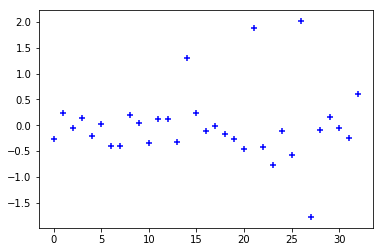

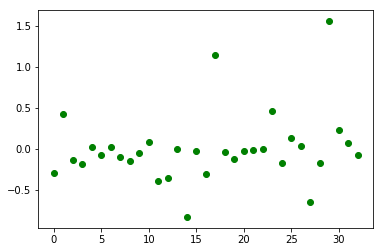

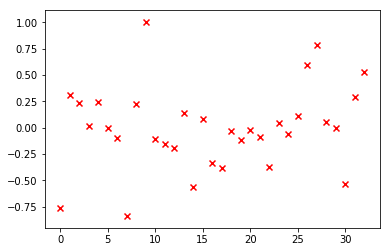

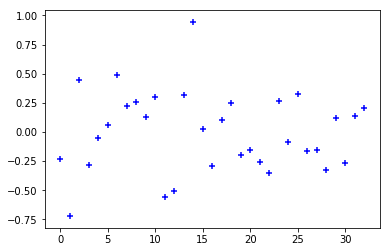

In [23]:
transformed_matrix = pca.transform(matrix)
for i in range(0, transformed_matrix.shape[1]):
    plt.figure()
    plt.scatter(rows, transformed_matrix[:, i], color=colors[i%3] ,marker=markers[i%3])
#     plt.show()
    plt.savefig('Images/Patient' + str(patient) + '/' + 'Transformed_' + str(i) + '.png')